<a href="https://colab.research.google.com/github/nonzuzo/ML-Movie-Analytics-Recommender-System/blob/Rachel/Final_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART** **A**

Environment Setup

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Set your data path (update this to match your Drive folder structure)
DATA_PATH = '/content/drive/MyDrive/ml-latest/ml-latest'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Inspect Data Files Without Loading


In [ ]:
def inspect_data_files(data_path):
    """
    Check file sizes and estimate memory requirements
    WITHOUT loading the full files
    """

    files_info = {}

    csv_files = [
        'ratings.csv',
        'movies.csv',
        'tags.csv',
        'genome-scores.csv',
        'genome-tags.csv',
        'links.csv'
    ]



    print("DATA FILES INSPECTION")


    for file in csv_files:
        filepath = os.path.join(data_path, file)

        if os.path.exists(filepath):
            # Get file size
            size_bytes = os.path.getsize(filepath)
            size_mb = size_bytes / (1024 * 1024)

            # Count rows (first 100 to estimate)
            with open(filepath, 'r') as f:
                # Skip header
                next(f)
                sample_lines = [next(f) for _ in range(min(100, sum(1 for _ in open(filepath))))]

            # Estimate total rows
            avg_line_size = sum(len(line.encode('utf-8')) for line in sample_lines) / len(sample_lines)
            estimated_rows = int(size_bytes / avg_line_size)

            # Estimate memory needed (roughly 2-3x file size)
            estimated_memory_mb = size_mb * 2.5

            files_info[file] = {
                'size_mb': size_mb,
                'estimated_rows': estimated_rows,
                'estimated_memory_mb': estimated_memory_mb
            }

            # Color coding for size
            if size_mb < 10:
                status = "🟢 SMALL"
            elif size_mb < 100:
                status = "🟡 MEDIUM"
            else:
                status = "🔴 LARGE"

            print(f"\n{status} {file}")
            print(f"  File Size: {size_mb:,.2f} MB")
            print(f"  Estimated Rows: {estimated_rows:,}")
            print(f"  Estimated Memory: {estimated_memory_mb:,.2f} MB")

        else:
            print(f"\n {file} - NOT FOUND")

    return files_info

# Run inspection
files_info = inspect_data_files(DATA_PATH)

# Check available RAM
import psutil
available_ram_gb = psutil.virtual_memory().available / (1024**3)

print(f" Available RAM: {available_ram_gb:.2f} GB ({available_ram_gb * 1024:.0f} MB)")


DATA FILES INSPECTION

🔴 LARGE ratings.csv
  File Size: 890.64 MB
  Estimated Rows: 44,471,375
  Estimated Memory: 2,226.59 MB

🟢 SMALL movies.csv
  File Size: 4.00 MB
  Estimated Rows: 92,301
  Estimated Memory: 10.00 MB

🟡 MEDIUM tags.csv
  File Size: 81.41 MB
  Estimated Rows: 2,864,490
  Estimated Memory: 203.52 MB

🔴 LARGE genome-scores.csv
  File Size: 497.36 MB
  Estimated Rows: 25,206,116
  Estimated Memory: 1,243.39 MB

🟢 SMALL genome-tags.csv
  File Size: 0.02 MB
  Estimated Rows: 1,318
  Estimated Memory: 0.04 MB

🟢 SMALL links.csv
  File Size: 1.84 MB
  Estimated Rows: 117,580
  Estimated Memory: 4.59 MB
 Available RAM: 4.34 GB (4447 MB)


 Efficient Data Loader for Large Datasets

In [ ]:


class EfficientMovieLensLoader:
    """
    Memory-efficient loader for MovieLens 33M dataset
    Uses chunking and some sampling strategies
    """

    def __init__(self, data_path):
        self.data_path = data_path
        self.ratings = None
        self.movies = None
        self.tags = None
        self.genome_scores = None
        self.genome_tags = None
        self.links = None

    def load_small_files(self):
        """Load files that are small enough for memory"""

        print(" Loading small/medium files...")

        # Movies (always small - ~86K rows)
        self.movies = pd.read_csv(os.path.join(self.data_path, 'movies.csv'))
        print(f"  Movies: {len(self.movies):,} rows")

        # Links (small)
        self.links = pd.read_csv(os.path.join(self.data_path, 'links.csv'))
        print(f"  Links: {len(self.links):,} rows")

        # Genome tags (small - ~1100 tags)
        self.genome_tags = pd.read_csv(os.path.join(self.data_path, 'genome-tags.csv'))
        print(f"  Genome Tags: {len(self.genome_tags):,} rows")

        # Tags (moderate size)
        try:
            self.tags = pd.read_csv(os.path.join(self.data_path, 'tags.csv'))
            print(f"  Tags: {len(self.tags):,} rows")
        except MemoryError:
            print("  Tags file too large, will load in chunks if needed")

        return self

    def load_ratings_sample(self, method='random', n_rows=1_000_000, **kwargs):
        """
        Load a sample of ratings using different strategies

        Parameters:
        -----------
        method : str
            'random' - Random sample (fastest)
            'head' - First N rows (fastest, but biased)
            'stratified' - Balanced sample by user activity
            'recent' - Most recent ratings
        n_rows : int
            Target number of rows to load
        """

        ratings_path = os.path.join(self.data_path, 'ratings.csv')

        print(f"\n Loading ratings sample using '{method}' method...")
        print(f"   Target: {n_rows:,} rows")

        if method == 'head':
            # Fastest: just load first N rows
            self.ratings = pd.read_csv(
                ratings_path,
                nrows=n_rows,
                dtype={
                    'userId': 'int32',
                    'movieId': 'int32',
                    'rating': 'float16'
                }
            )

        elif method == 'random':
            # Random sampling - good for unbiased sample
            # First, count total rows
            print("   Counting total rows...")
            total_rows = sum(1 for _ in open(ratings_path)) - 1
            print(f"   Total ratings in dataset: {total_rows:,}")

            # Calculate skip probability
            skip_prob = 1 - (n_rows / total_rows)

            # Load with random skipping
            print("   Sampling...")
            np.random.seed(42)
            self.ratings = pd.read_csv(
                ratings_path,
                dtype={
                    'userId': 'int32',
                    'movieId': 'int32',
                    'rating': 'float16'
                },
                skiprows=lambda i: i > 0 and np.random.random() < skip_prob
            )

        elif method == 'stratified':
            # More sophisticated: ensure diverse user representation
            print("   Phase 1: Scanning for user distribution...")

            user_rating_counts = {}
            chunk_size = 1_000_000

            for i, chunk in enumerate(pd.read_csv(ratings_path,
                                                  chunksize=chunk_size,
                                                  usecols=['userId'])):
                counts = chunk['userId'].value_counts()
                for user_id, count in counts.items():
                    user_rating_counts[user_id] = user_rating_counts.get(user_id, 0) + count

                if (i + 1) % 10 == 0:
                    print(f"     Processed {(i+1) * chunk_size:,} rows...")

            print(f"   Found {len(user_rating_counts):,} unique users")

            # Categorize users by activity level
            user_counts_series = pd.Series(user_rating_counts)

            # Define tiers
            power_threshold = user_counts_series.quantile(0.90)
            active_threshold = user_counts_series.quantile(0.50)

            power_users = user_counts_series[user_counts_series >= power_threshold].index.tolist()
            active_users = user_counts_series[
                (user_counts_series >= active_threshold) &
                (user_counts_series < power_threshold)
            ].index.tolist()
            casual_users = user_counts_series[user_counts_series < active_threshold].index.tolist()

            print(f"   User distribution:")
            print(f"     Power users (top 10%): {len(power_users):,}")
            print(f"     Active users (50-90%): {len(active_users):,}")
            print(f"     Casual users (bottom 50%): {len(casual_users):,}")

            # Sample users from each tier
            n_sample_users = min(5000, int(np.sqrt(n_rows)))

            sample_power = np.random.choice(
                power_users,
                size=min(len(power_users), n_sample_users // 3),
                replace=False
            )
            sample_active = np.random.choice(
                active_users,
                size=min(len(active_users), n_sample_users // 3),
                replace=False
            )
            sample_casual = np.random.choice(
                casual_users,
                size=min(len(casual_users), n_sample_users // 3),
                replace=False
            )

            sampled_users = set(list(sample_power) + list(sample_active) + list(sample_casual))

            print(f"   Phase 2: Loading ratings for {len(sampled_users):,} sampled users...")

            # Load ratings for selected users
            ratings_chunks = []
            for i, chunk in enumerate(pd.read_csv(
                ratings_path,
                chunksize=chunk_size,
                dtype={
                    'userId': 'int32',
                    'movieId': 'int32',
                    'rating': 'float16'
                }
            )):
                filtered = chunk[chunk['userId'].isin(sampled_users)]
                if len(filtered) > 0:
                    ratings_chunks.append(filtered)

                if (i + 1) % 10 == 0:
                    print(f"     Processed {(i+1) * chunk_size:,} rows...")

            self.ratings = pd.concat(ratings_chunks, ignore_index=True)

            # If still too large, sample down
            if len(self.ratings) > n_rows:
                self.ratings = self.ratings.sample(n=n_rows, random_state=42)

        elif method == 'recent':
            # Load most recent ratings (by timestamp)
            print("   Loading and sorting by timestamp...")
            self.ratings = pd.read_csv(
                ratings_path,
                dtype={
                    'userId': 'int32',
                    'movieId': 'int32',
                    'rating': 'float16'
                }
            )
            self.ratings = self.ratings.nlargest(n_rows, 'timestamp')

        # Convert timestamp
        print("   Converting timestamps...")
        self.ratings['timestamp'] = pd.to_datetime(self.ratings['timestamp'], unit='s')

        # Memory usage
        memory_mb = self.ratings.memory_usage(deep=True).sum() / (1024**2)

        print(f"\n Ratings loaded successfully!")
        print(f"   Actual rows: {len(self.ratings):,}")
        print(f"   Unique users: {self.ratings['userId'].nunique():,}")
        print(f"   Unique movies: {self.ratings['movieId'].nunique():,}")
        print(f"   Memory usage: {memory_mb:.2f} MB")
        print(f"   Date range: {self.ratings['timestamp'].min()} to {self.ratings['timestamp'].max()}")

        return self

    def save_sample(self, output_path='/content/drive/MyDrive/MovieLens_Processed/'):
        """Save the loaded sample for reuse"""

        os.makedirs(output_path, exist_ok=True)

        timestamp = datetime.now().strftime('%Y%m%d_%H%M')

        if self.ratings is not None:
            filename = f'ratings_sample_{len(self.ratings)}_rows_{timestamp}.csv'
            filepath = os.path.join(output_path, filename)
            self.ratings.to_csv(filepath, index=False)
            print(f" Ratings sample saved: {filename}")

        if self.movies is not None:
            self.movies.to_csv(os.path.join(output_path, 'movies.csv'), index=False)
            print(f" Movies saved")

        return self


loader = EfficientMovieLensLoader(DATA_PATH)

Loading Data

In [ ]:
loader.load_small_files()
# OPTION A: Random sample (RECOMMENDED - fastest, unbiased)
loader.load_ratings_sample(method='random', n_rows=1_000_000)

# OPTION B: Stratified sample (better user diversity, slower)
# loader.load_ratings_sample(method='stratified', n_rows=1_000_000)

# OPTION C: Recent ratings (good for trends)
# loader.load_ratings_sample(method='recent', n_rows=1_000_000)

# OPTION D: First N rows (fastest but biased)
# loader.load_ratings_sample(method='head', n_rows=1_000_000)
loader.save_sample()
# Access the data
ratings = loader.ratings
movies = loader.movies
tags = loader.tags
genome_tags = loader.genome_tags
genome_scores=loader.genome_scores #remember to come back here !!!!!!!!!!!!
links = loader.links


print("🎉 DATA LOADED ")

print(f"\n The Various legnths are :")
print(f"  • ratings: {len(ratings):,} rows")
print(f"  • movies: {len(movies):,} rows")
print(f"  • tags: {len(tags):,} rows" if tags is not None else "  • tags: Not loaded")
print(f"  • genome_tags: {len(genome_tags):,} rows")
# print(f"  • genome_scores: {len(genome_scores):,} rows")

 Loading small/medium files...
  Movies: 86,537 rows
  Links: 86,537 rows
  Genome Tags: 1,128 rows
  Tags: 2,328,315 rows

 Loading ratings sample using 'random' method...
   Target: 1,000,000 rows
   Counting total rows...
   Total ratings in dataset: 33,832,162
   Sampling...
   Converting timestamps...

 Ratings loaded successfully!
   Actual rows: 999,087
   Unique users: 200,402
   Unique movies: 27,121
   Memory usage: 17.15 MB
   Date range: 1996-01-29 00:00:00 to 2023-07-20 08:53:33
 Ratings sample saved: ratings_sample_999087_rows_20251209_1328.csv
 Movies saved
🎉 DATA LOADED 

 The Various legnths are :
  • ratings: 999,087 rows
  • movies: 86,537 rows
  • tags: 2,328,315 rows
  • genome_tags: 1,128 rows


## **Data Understanding & Pre-Processing**

In [ ]:
print("1. DATASET OVERVIEW")


print(f"\n RATINGS DATASET:")
print(f"   Total ratings: {len(ratings):,}")
print(f"   Unique users: {ratings['userId'].nunique():,}")
print(f"   Unique movies: {ratings['movieId'].nunique():,}")
print(f"   Rating scale: {ratings['rating'].min()} to {ratings['rating'].max()}")
print(f"   Date range: {ratings['timestamp'].min().date()} to {ratings['timestamp'].max().date()}")

# Calculate sparsity
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)
sparsity = 1 - (n_ratings / (n_users * n_movies))
print(f"   Sparsity: {sparsity*100:.4f}%")

print(f"\n🎬 MOVIES DATASET:")
print(f"   Total movies: {len(movies):,}")
print(f"   Movies with ratings: {ratings['movieId'].nunique():,}")
print(f"   Coverage: {(ratings['movieId'].nunique() / len(movies)) * 100:.2f}%")

print(f"\n TAGS DATASET:")
if tags is not None:
    print(f"   Total tags: {len(tags):,}")
    print(f"   Unique tags: {tags['tag'].nunique():,}")
    print(f"   Users who tagged: {tags['userId'].nunique():,}")

print(f"\n  GENOME TAGS:")
print(f"   Tag genome vocabulary: {len(genome_tags):,} tags")


1. DATASET OVERVIEW

 RATINGS DATASET:
   Total ratings: 999,087
   Unique users: 200,402
   Unique movies: 27,121
   Rating scale: 0.5 to 5.0
   Date range: 1996-01-29 to 2023-07-20
   Sparsity: 99.9816%

🎬 MOVIES DATASET:
   Total movies: 86,537
   Movies with ratings: 27,121
   Coverage: 31.34%

 TAGS DATASET:
   Total tags: 2,328,315
   Unique tags: 153,949
   Users who tagged: 25,280

  GENOME TAGS:
   Tag genome vocabulary: 1,128 tags


CHECK FOR MISSING DATA

In [ ]:

print("2. MISSING DATA ANALYSIS")


print("\n RATINGS - Missing Values:")
missing_ratings = ratings.isnull().sum()
print(missing_ratings)
if missing_ratings.sum() == 0:
    print(" No missing values in ratings!")

print("\n🎬 MOVIES - Missing Values:")
missing_movies = movies.isnull().sum()
print(missing_movies)

# Check for movies with no genre
no_genre = movies[movies['genres'] == '(no genres listed)']
print(f"\n Movies with no genres listed: {len(no_genre):,}")
if len(no_genre) > 0:
    print("   Sample:")
    print(no_genre[['movieId', 'title', 'genres']].head())

2. MISSING DATA ANALYSIS

 RATINGS - Missing Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
 No missing values in ratings!

🎬 MOVIES - Missing Values:
movieId    0
title      0
genres     0
dtype: int64

 Movies with no genres listed: 7,060
   Sample:
       movieId                                            title  \
15884    83773            Away with Words (San tiao ren) (1999)   
16063    84768                                Glitterbug (1994)   
16354    86493  Age of the Earth, The (A Idade da Terra) (1980)   
16494    87061                          Trails (Veredas) (1978)   
17410    91246                         Milky Way (Tejút) (2007)   

                   genres  
15884  (no genres listed)  
16063  (no genres listed)  
16354  (no genres listed)  
16494  (no genres listed)  
17410  (no genres listed)  


CHECK FOR DUPLICATES

In [ ]:
print("3. DUPLICATE ANALYSIS")


# Check for duplicate ratings (same user rating same movie multiple times)
duplicates = ratings.duplicated(subset=['userId', 'movieId'], keep=False)
n_duplicates = duplicates.sum()

print(f"\n Duplicate ratings (same user-movie pairs): {n_duplicates:,}")

if n_duplicates > 0:
    print("\n   Sample of duplicates:")
    dup_sample = ratings[duplicates].sort_values(['userId', 'movieId', 'timestamp']).head(10)
    print(dup_sample[['userId', 'movieId', 'rating', 'timestamp']])

    # Strategy: Keep the most recent rating
    print("\n   Removing duplicates (keeping most recent rating)...")
    ratings_clean = ratings.sort_values('timestamp').drop_duplicates(
        subset=['userId', 'movieId'],
        keep='last'
    )
    print(f"   Removed {len(ratings) - len(ratings_clean):,} duplicate ratings")
    ratings = ratings_clean
else:
    print(" No duplicates found!")


3. DUPLICATE ANALYSIS

 Duplicate ratings (same user-movie pairs): 0
 No duplicates found!


PARSE GENRES

In [ ]:
print("4. GENRE PARSING")


# Split genres into list
movies['genres_list'] = movies['genres'].str.split('|')
movies['n_genres'] = movies['genres_list'].apply(len)

print(f"\n Genre Statistics:")
print(f"   Unique genre combinations: {movies['genres'].nunique():,}")
print(f"   Average genres per movie: {movies['n_genres'].mean():.2f}")
print(f"   Max genres per movie: {movies['n_genres'].max()}")

# Get all unique genres
all_genres = []
for genre_list in movies['genres_list']:
    all_genres.extend([g for g in genre_list if g != '(no genres listed)'])

unique_genres = sorted(set(all_genres))
print(f"   Unique individual genres: {len(unique_genres)}")
print(f"   Genre list: {', '.join(unique_genres)}")


4. GENRE PARSING

 Genre Statistics:
   Unique genre combinations: 1,796
   Average genres per movie: 1.76
   Max genres per movie: 10
   Unique individual genres: 19
   Genre list: Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western


PARSE MOVIE TITLES & EXTRACT YEARS

In [ ]:
print("5. MOVIE TITLE & YEAR PARSING")


# Extract year from title (format: "Movie Title (YYYY)")
movies['release_year'] = movies['title'].str.extract(r'\((\d{4})\)$')[0].astype('float')

# Clean title (remove year)
movies['title_clean'] = movies['title'].str.replace(r'\s*\(\d{4}\)\s*$', '', regex=True)

# Check for missing years
missing_years = movies['release_year'].isnull().sum()
print(f"\n Movies with release year: {len(movies) - missing_years:,}")
print(f"   Movies without release year: {missing_years:,}")

if missing_years > 0:
    print("\n   Sample movies without year:")
    print(movies[movies['release_year'].isnull()][['movieId', 'title']].head())

# Year distribution
print(f"\n   Year range: {int(movies['release_year'].min())} to {int(movies['release_year'].max())}")
print(f"   Median year: {int(movies['release_year'].median())}")

5. MOVIE TITLE & YEAR PARSING

 Movies with release year: 85,763
   Movies without release year: 774

   Sample movies without year:
      movieId                               title
8465    25936        Babe Ruth Story, The (1948) 
8604    26137     Heroes of Telemark, The (1965) 
8912    26628                 Jack's Back (1988) 
9122    27189  After the Rain (Ame agaru) (1999) 
9765    32497                 Love Letter (1995) 

   Year range: 1874 to 2023
   Median year: 2005


TIMESTAMP TRANSFORMATION

In [ ]:
print("6. TIMESTAMP FEATURE ENGINEERING")


# Extract temporal features
ratings['year'] = ratings['timestamp'].dt.year
ratings['month'] = ratings['timestamp'].dt.month
ratings['day_of_week'] = ratings['timestamp'].dt.dayofweek
ratings['hour'] = ratings['timestamp'].dt.hour
ratings['date'] = ratings['timestamp'].dt.date

print(f"\n Temporal Features Added:")
print(f"   Year range: {ratings['year'].min()} to {ratings['year'].max()}")
print(f"   Month range: {ratings['month'].min()} to {ratings['month'].max()}")

# Day of week distribution
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
print(f"\n   Ratings by day of week:")
for day_num in range(7):
    count = (ratings['day_of_week'] == day_num).sum()
    print(f"     {day_names[day_num]}: {count:,}")

6. TIMESTAMP FEATURE ENGINEERING

 Temporal Features Added:
   Year range: 1996 to 2023
   Month range: 1 to 12

   Ratings by day of week:
     Monday: 152,573
     Tuesday: 147,335
     Wednesday: 137,032
     Thursday: 130,041
     Friday: 134,796
     Saturday: 141,547
     Sunday: 155,763


# Basic Analysis (Rating Distribution)

RATING DISTRIBUTION ANALYSIS

 Rating Statistics:
count    999087.0
mean          NaN
std           0.0
min           0.5
25%           3.0
50%           3.5
75%           4.0
max           5.0
Name: rating, dtype: float64

 Rating Distribution:
   0.5 ⭐:   16,792 ( 1.68%) 
   1.0 ⭐:   30,294 ( 3.03%) █
   1.5 ⭐:   16,487 ( 1.65%) 
   2.0 ⭐:   63,787 ( 6.38%) ███
   2.5 ⭐:   51,887 ( 5.19%) ██
   3.0 ⭐:  188,442 (18.86%) █████████
   3.5 ⭐:  131,907 (13.20%) ██████
   4.0 ⭐:  260,790 (26.10%) █████████████
   4.5 ⭐:   92,258 ( 9.23%) ████
   5.0 ⭐:  146,443 (14.66%) ███████


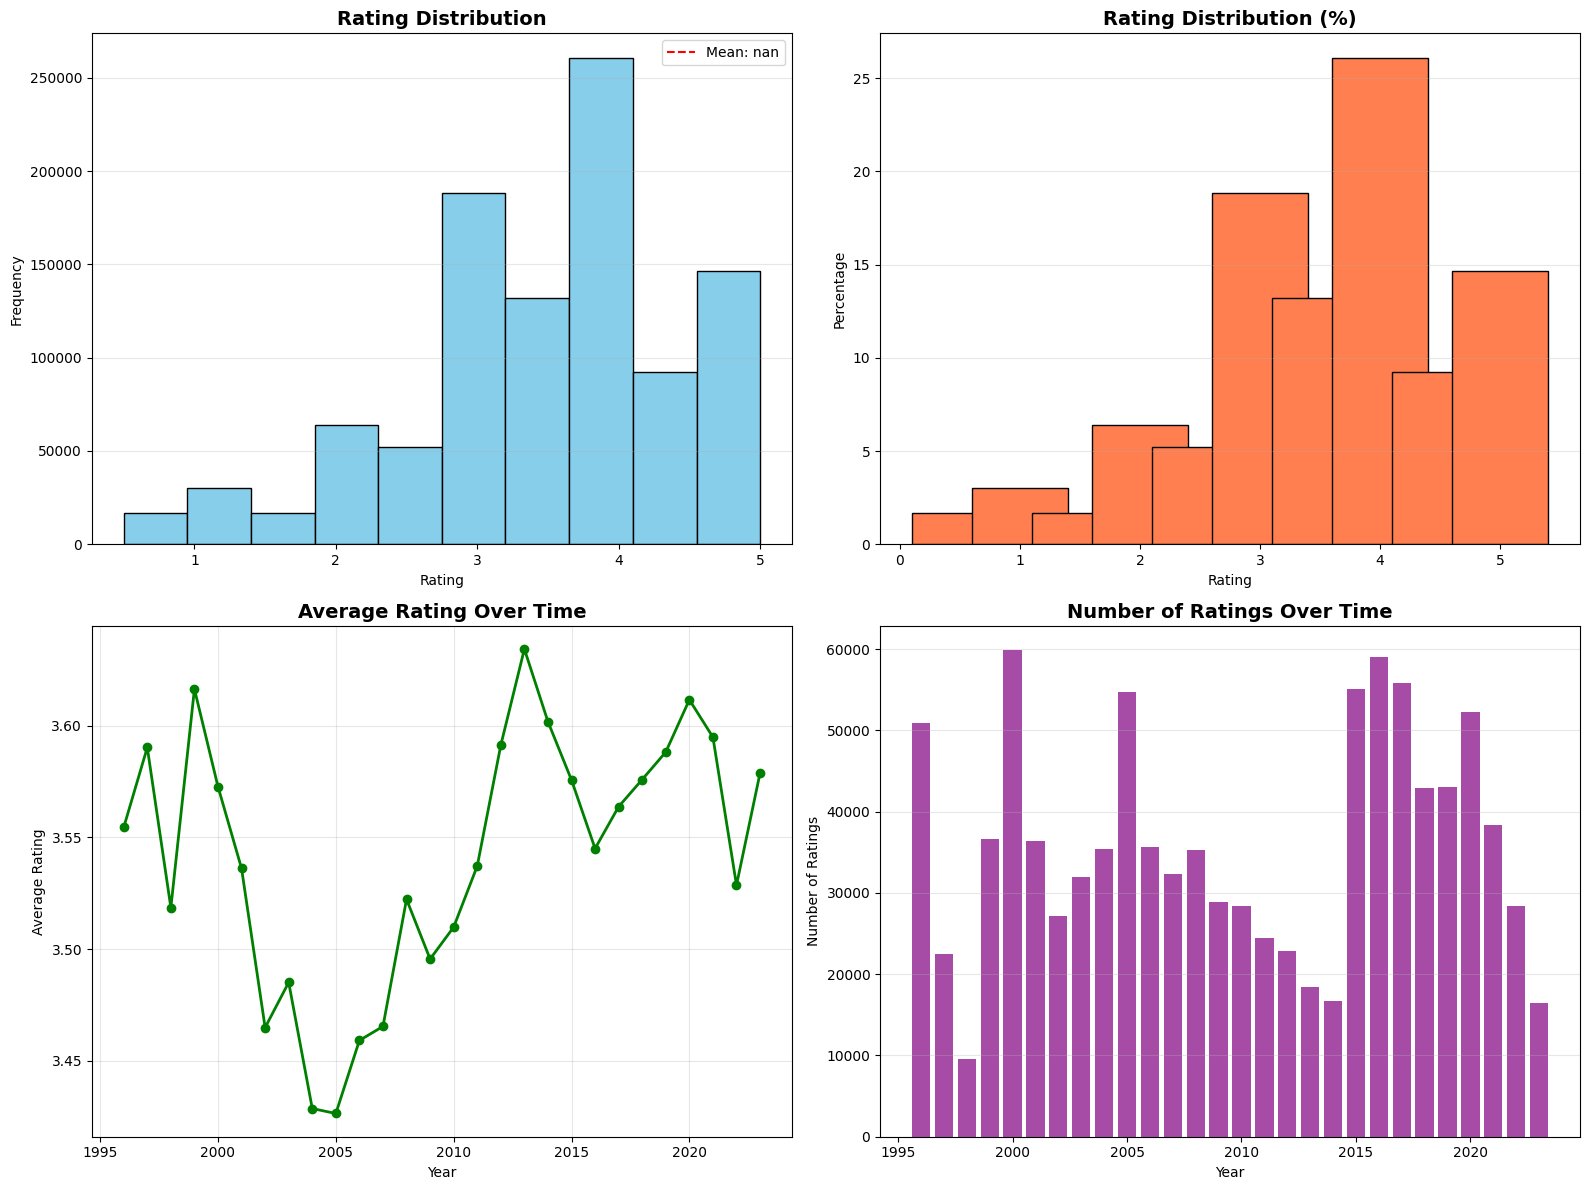


 Rating distribution analysis complete
 Chart saved as 'rating_distribution.png'


In [ ]:

print("RATING DISTRIBUTION ANALYSIS")

# Overall rating statistics
print(f"\n Rating Statistics:")
print(ratings['rating'].describe())

print(f"\n Rating Distribution:")
rating_dist = ratings['rating'].value_counts().sort_index()
for rating, count in rating_dist.items():
    percentage = (count / len(ratings)) * 100
    bar = '█' * int(percentage / 2)
    print(f"   {rating:.1f} ⭐: {count:>8,} ({percentage:5.2f}%) {bar}")

# Visualize rating distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Rating histogram
axes[0, 0].hist(ratings['rating'], bins=10, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add mean line
mean_rating = ratings['rating'].mean()
axes[0, 0].axvline(mean_rating, color='red', linestyle='--',
                   label=f'Mean: {mean_rating:.2f}')
axes[0, 0].legend()

# 2. Rating distribution as percentages
rating_pct = (rating_dist / len(ratings)) * 100
axes[0, 1].bar(rating_pct.index, rating_pct.values, color='coral', edgecolor='black')
axes[0, 1].set_title('Rating Distribution (%)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Ratings over time
yearly_avg = ratings.groupby('year')['rating'].agg(['mean', 'count'])
axes[1, 0].plot(yearly_avg.index, yearly_avg['mean'], marker='o', linewidth=2, color='green')
axes[1, 0].set_title('Average Rating Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].grid(True, alpha=0.3)

# 4. Number of ratings over time
axes[1, 1].bar(yearly_avg.index, yearly_avg['count'], color='purple', alpha=0.7)
axes[1, 1].set_title('Number of Ratings Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Number of Ratings')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Rating distribution analysis complete")
print(" Chart saved as 'rating_distribution.png'")

# User Behavior Analysis

In [ ]:

print("USER RATING BEHAVIOR ANALYSIS")


# Compute user statistics
user_stats = ratings.groupby('userId').agg({
    'rating': ['count', 'mean', 'std', 'min', 'max'],
    'movieId': 'nunique',
    'timestamp': ['min', 'max']
}).reset_index()

user_stats.columns = ['userId', 'n_ratings', 'avg_rating', 'rating_std',
                      'min_rating', 'max_rating', 'n_movies',
                      'first_rating', 'last_rating']

# Calculate user tenure
user_stats['tenure_days'] = (user_stats['last_rating'] -
                              user_stats['first_rating']).dt.days

# Ratings per day
user_stats['ratings_per_day'] = user_stats['n_ratings'] / (user_stats['tenure_days'] + 1)

print(f"\n👥 User Behavior Statistics:")
print(user_stats[['n_ratings', 'avg_rating', 'rating_std', 'tenure_days']].describe())



USER RATING BEHAVIOR ANALYSIS

👥 User Behavior Statistics:
           n_ratings     avg_rating     rating_std    tenure_days
count  200402.000000  200402.000000  130782.000000  200402.000000
mean        4.985414       3.679642       0.803297     162.771709
std         8.532888       0.859680       0.506248     666.831159
min         1.000000       0.500000       0.000000       0.000000
25%         1.000000       3.156250       0.500000       0.000000
50%         2.000000       3.750000       0.707107       0.000000
75%         5.000000       4.227273       1.060660       0.000000
max       960.000000       5.000000       3.181981    9416.000000


In [ ]:

# CLASSIFY USERS BY RATING BEHAVIOR


# 1. By average rating (bias)
user_stats['rating_bias'] = pd.cut(
    user_stats['avg_rating'],
    bins=[0, 2.5, 3.5, 5.0],
    labels=['Harsh', 'Moderate', 'Generous']
)

print(f"\n User Rating Bias Distribution:")
bias_dist = user_stats['rating_bias'].value_counts()
for bias_type, count in bias_dist.items():
    percentage = (count / len(user_stats)) * 100
    print(f"   {bias_type:12s}: {count:>6,} users ({percentage:5.2f}%)")

# 2. By activity level
user_stats['activity_level'] = pd.cut(
    user_stats['n_ratings'],
    bins=[0, 20, 100, 500, float('inf')],
    labels=['Light', 'Regular', 'Active', 'Power']
)

print(f"\n User Activity Distribution:")
activity_dist = user_stats['activity_level'].value_counts()
for activity, count in activity_dist.items():
    percentage = (count / len(user_stats)) * 100
    avg_ratings = user_stats[user_stats['activity_level'] == activity]['n_ratings'].mean()
    print(f"   {activity:12s}: {count:>6,} users ({percentage:5.2f}%) - Avg: {avg_ratings:.0f} ratings")




 User Rating Bias Distribution:
   Generous    : 117,553 users (58.66%)
   Moderate    : 64,279 users (32.08%)
   Harsh       : 18,570 users ( 9.27%)

 User Activity Distribution:
   Light       : 192,648 users (96.13%) - Avg: 4 ratings
   Regular     :  7,619 users ( 3.80%) - Avg: 34 ratings
   Active      :    134 users ( 0.07%) - Avg: 137 ratings
   Power       :      1 users ( 0.00%) - Avg: 960 ratings


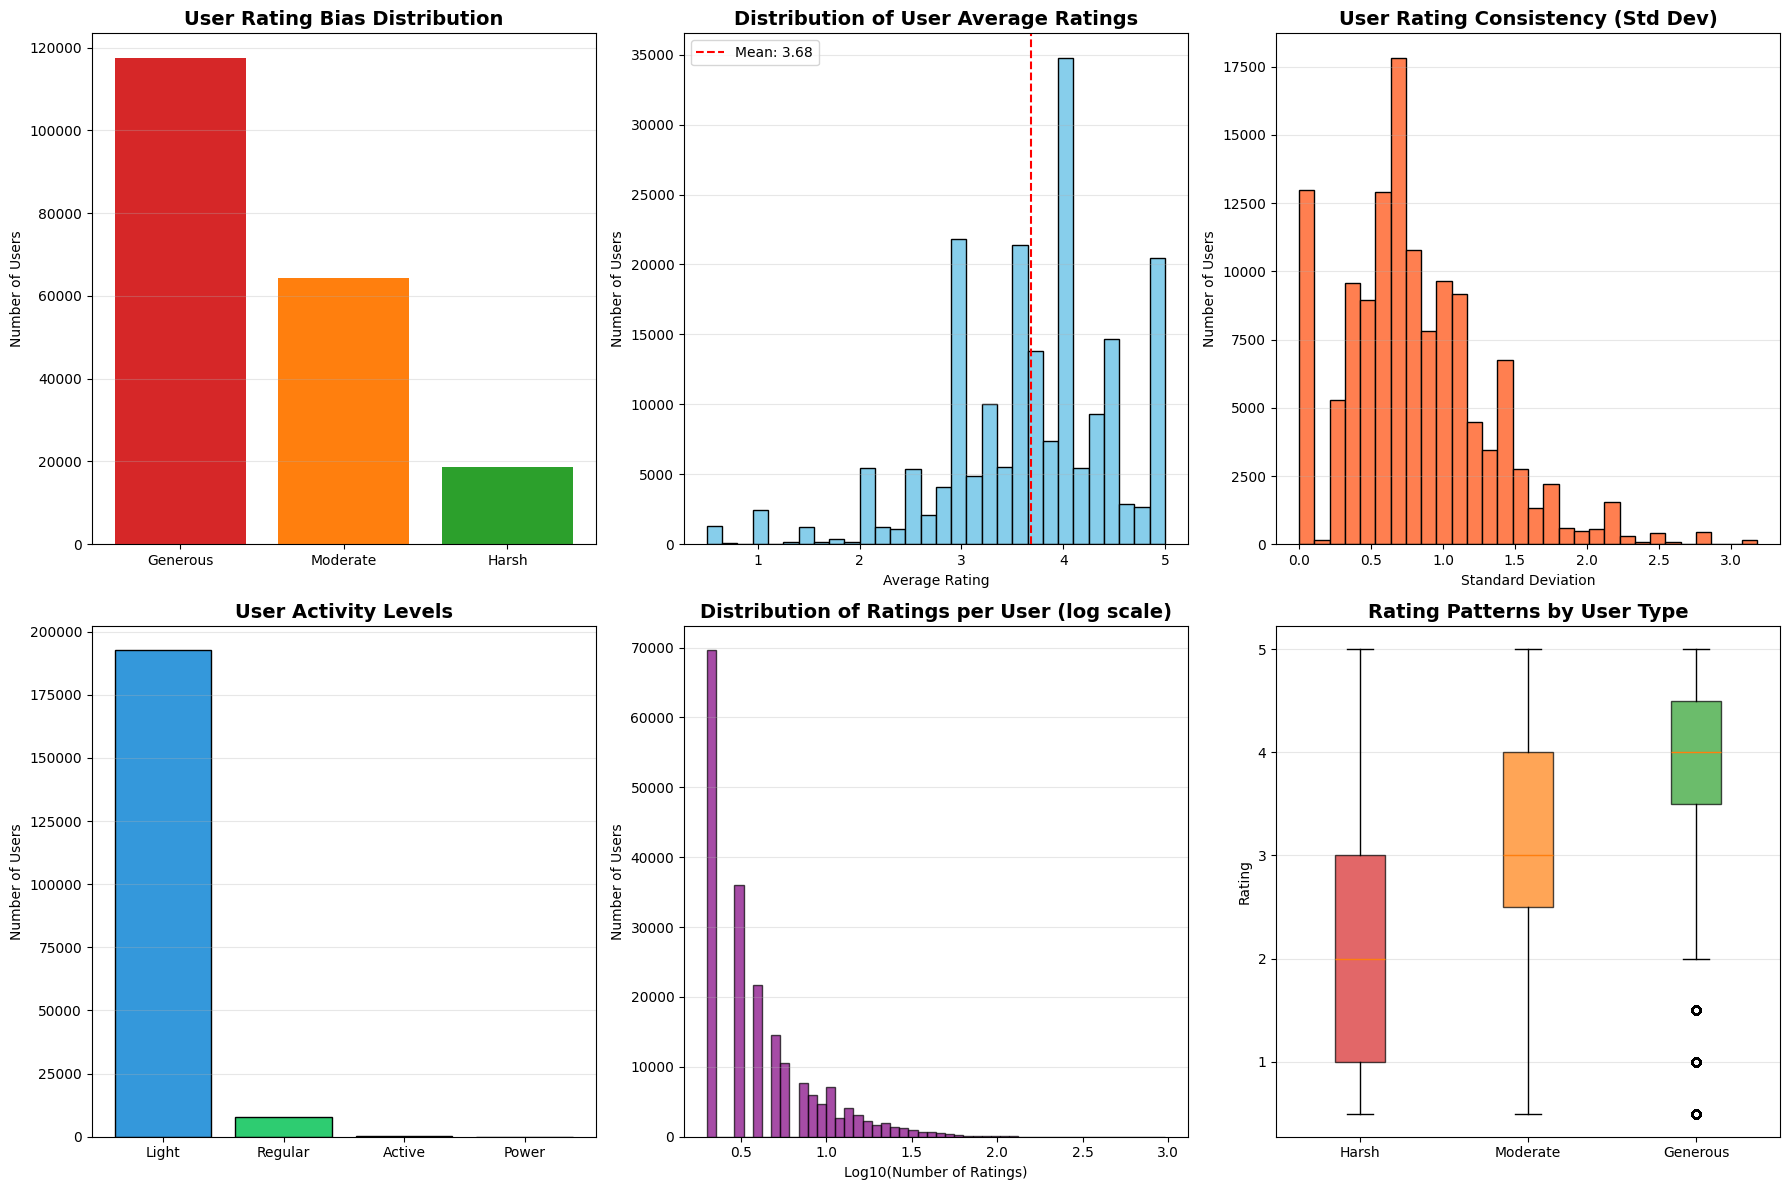

 Chart saved as 'user_behavior_analysis.png'
KEY INSIGHTS - USER BEHAVIOR

 Rating Bias:
   Harsh       : Avg rating = 1.87
   Moderate    : Avg rating = 3.18
   Generous    : Avg rating = 4.24

 Activity Patterns:
   Light       : Avg 4 ratings over 103 days
   Regular     : Avg 34 ratings over 1612 days
   Active      : Avg 137 ratings over 3165 days
   Power       : Avg 960 ratings over 1641 days

 Top 10 Most Active Users:
 userId  n_ratings  avg_rating  tenure_days
 189614        960    3.051042         1641
  48766        311    2.580386         3797
 207216        301    3.284053         4589
 175998        259    3.229730         4266
  76618        258    2.558140         4541
 184775        243    2.823045         7632
 214831        237    1.453586         8481
 233891        229    2.390830          660
 236260        220    3.202273         2089
 230765        219    3.445205         7979


In [ ]:
# VISUALIZE USER BEHAVIORS


fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. User rating bias distribution
bias_counts = user_stats['rating_bias'].value_counts()
axes[0, 0].bar(bias_counts.index.astype(str), bias_counts.values,
               color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0, 0].set_title('User Rating Bias Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Average rating distribution
axes[0, 1].hist(user_stats['avg_rating'], bins=30, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Distribution of User Average Ratings', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].axvline(user_stats['avg_rating'].mean(), color='red', linestyle='--', label=f"Mean: {user_stats['avg_rating'].mean():.2f}")
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Rating consistency (std dev)

axes[0, 2].hist(user_stats['rating_std'].dropna(), bins=30, color='coral', edgecolor='black')
axes[0, 2].set_title('User Rating Consistency (Std Dev)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Standard Deviation')
axes[0, 2].set_ylabel('Number of Users')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Activity level distribution
activity_counts = user_stats['activity_level'].value_counts().sort_index()
colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
axes[1, 0].bar(range(len(activity_counts)), activity_counts.values,
               color=colors, edgecolor='black')
axes[1, 0].set_title('User Activity Levels', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(len(activity_counts)))
axes[1, 0].set_xticklabels(activity_counts.index, rotation=0)
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Number of ratings per user (log scale)
axes[1, 1].hist(np.log10(user_stats['n_ratings'] + 1), bins=50,
                color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Distribution of Ratings per User (log scale)',
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Log10(Number of Ratings)')
axes[1, 1].set_ylabel('Number of Users')
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Ratings by user bias type
merged_bias = ratings.merge(user_stats[['userId', 'rating_bias']], on='userId')
bias_data = [
    merged_bias[merged_bias['rating_bias'] == 'Harsh']['rating'].dropna(),
    merged_bias[merged_bias['rating_bias'] == 'Moderate']['rating'].dropna(),
    merged_bias[merged_bias['rating_bias'] == 'Generous']['rating'].dropna()
]
bp = axes[1, 2].boxplot(bias_data, labels=['Harsh', 'Moderate', 'Generous'],
                        patch_artist=True)
for patch, color in zip(bp['boxes'], ['#d62728', '#ff7f0e', '#2ca02c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 2].set_title('Rating Patterns by User Type', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Rating')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/user_behavior_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


print(" Chart saved as 'user_behavior_analysis.png'")

# Print key insights

print("KEY INSIGHTS - USER BEHAVIOR")

print(f"\n Rating Bias:")
for bias_type in ['Harsh', 'Moderate', 'Generous']:
    bias_users = user_stats[user_stats['rating_bias'] == bias_type]
    if len(bias_users) > 0:
        avg = bias_users['avg_rating'].mean()
        print(f"   {bias_type:12s}: Avg rating = {avg:.2f}")

print(f"\n Activity Patterns:")
for activity in ['Light', 'Regular', 'Active', 'Power']:
    active_users = user_stats[user_stats['activity_level'] == activity]
    if len(active_users) > 0:
        avg_ratings = active_users['n_ratings'].mean()
        avg_tenure = active_users['tenure_days'].mean()
        print(f"   {activity:12s}: Avg {avg_ratings:.0f} ratings over {avg_tenure:.0f} days")

# Most active users
print(f"\n Top 10 Most Active Users:")
top_users = user_stats.nlargest(10, 'n_ratings')[['userId', 'n_ratings', 'avg_rating', 'tenure_days']]
print(top_users.to_string(index=False))



# Genre Analysis

GENRE ANALYSIS

 GENRE PERFORMANCE SUMMARY:
   Total genres: 19
   Total ratings analyzed: 2,717,742

 Top 10 Genres by Average Rating:
      genre  avg_rating  n_ratings  n_movies
  Film-Noir    3.920293       9491       225
        War    3.795786      50070       951
Documentary    3.699273      13060      2045
      Crime    3.696727     168663      2748
      Drama    3.683630     437072     12178
    Mystery    3.675802      81464      1501
  Animation    3.614162      68683      1679
       IMAX    3.604219      45985       179
    Western    3.592945      18710       481
    Musical    3.549876      36420       668

 Top 10 Most Popular Genres (by number of ratings):
    genre  n_ratings  avg_rating  n_movies
    Drama     437072    3.683630     12178
   Comedy     349461    3.430227      8426
   Action     301201    3.479102      3731
 Thriller     271402    3.535134      4595
Adventure     237870    3.525131      2385
   Sci-Fi     177969    3.495988      2057
  Romance     1

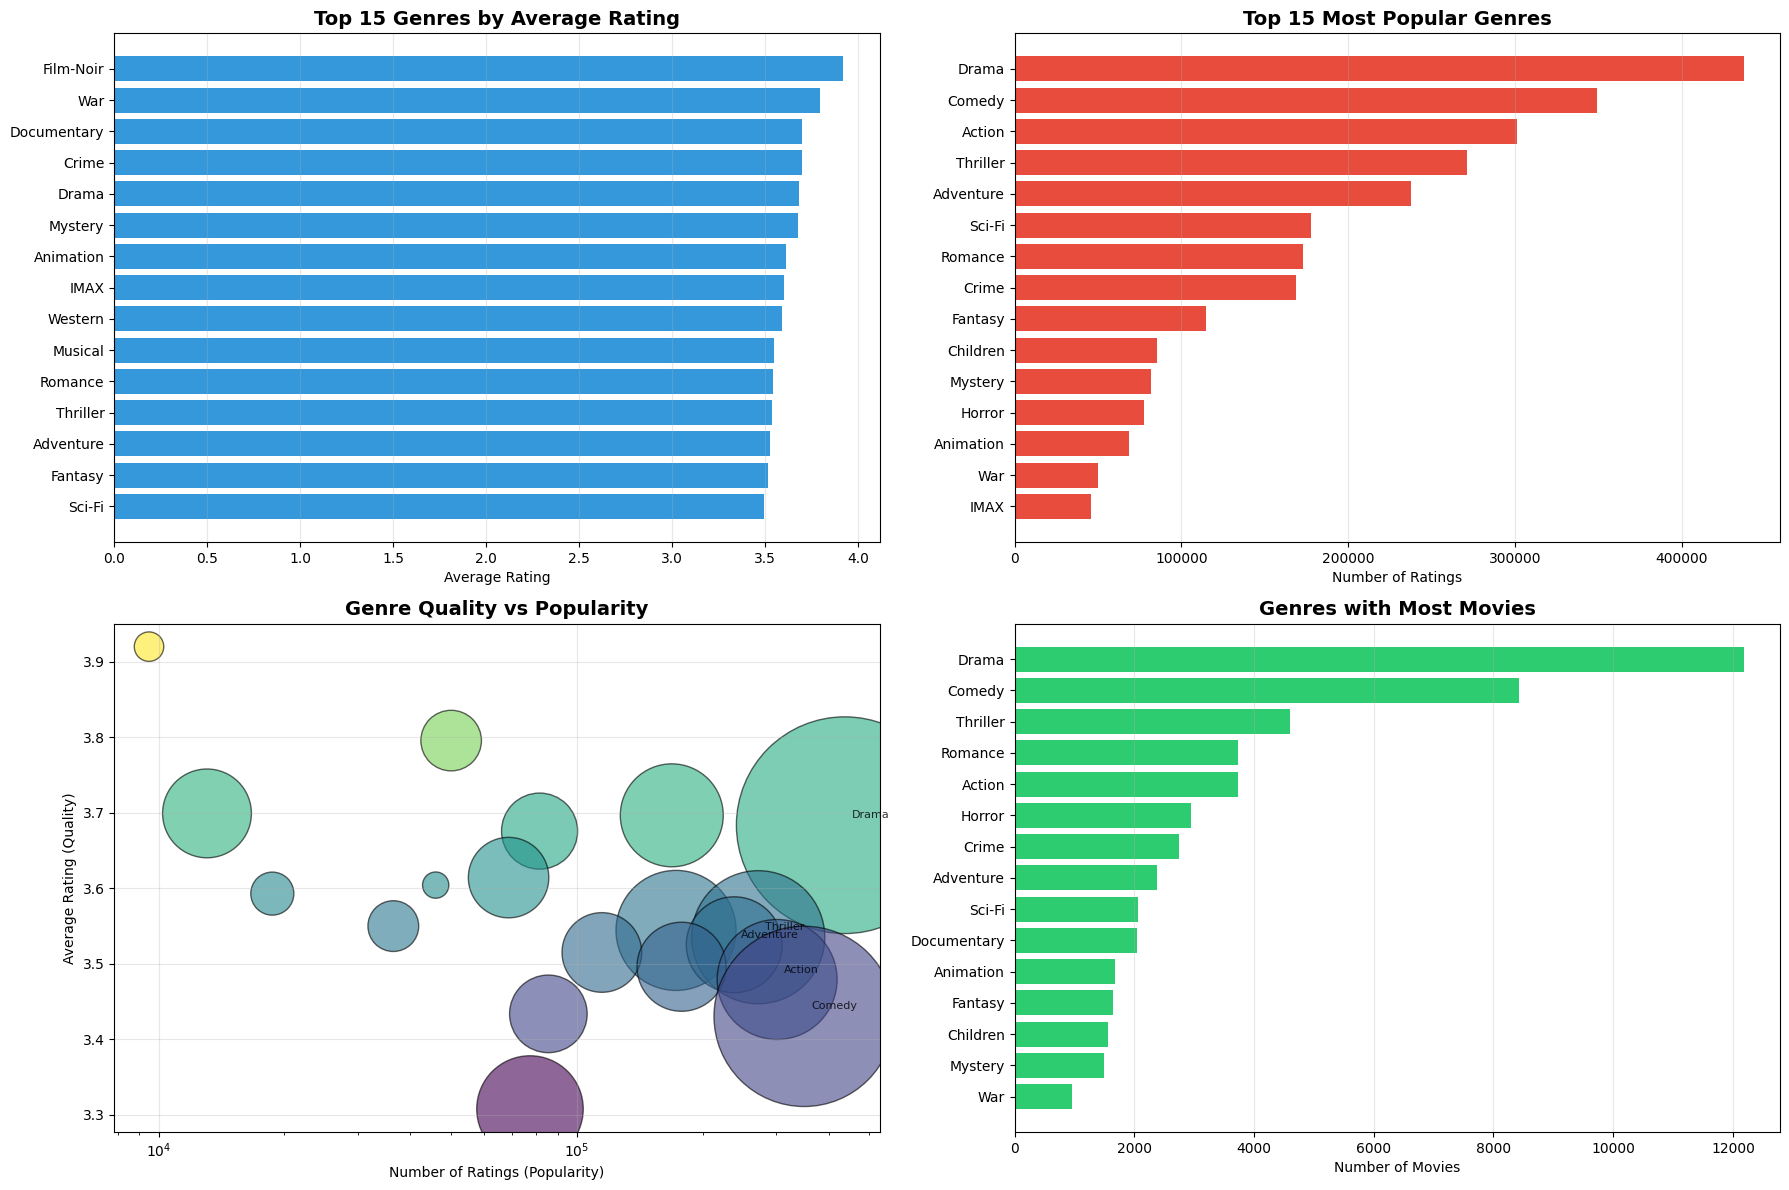

 Chart saved as 'genre_analysis.png'


In [ ]:



print("GENRE ANALYSIS")


# Explode genres to analyze individually
movies_exploded = movies.explode('genres_list')

# Remove '(no genres listed)'
movies_exploded = movies_exploded[movies_exploded['genres_list'] != '(no genres listed)']

# Merge with ratings to get genre performance
genre_ratings = movies_exploded.merge(
    ratings[['movieId', 'rating']],
    on='movieId'
)

# Compute genre statistics
genre_stats = genre_ratings.groupby('genres_list').agg({
    'rating': ['mean', 'count', 'std', 'median'],
    'movieId': 'nunique'
}).reset_index()

genre_stats.columns = ['genre', 'avg_rating', 'n_ratings', 'rating_std',
                       'median_rating', 'n_movies']

# Sort by average rating
genre_stats = genre_stats.sort_values('avg_rating', ascending=False)

print("\n GENRE PERFORMANCE SUMMARY:")
print(f"   Total genres: {len(genre_stats)}")
print(f"   Total ratings analyzed: {len(genre_ratings):,}")

print("\n Top 10 Genres by Average Rating:")
print(genre_stats.head(10)[['genre', 'avg_rating', 'n_ratings', 'n_movies']].to_string(index=False))

print("\n Top 10 Most Popular Genres (by number of ratings):")
top_popular = genre_stats.nlargest(10, 'n_ratings')
print(top_popular[['genre', 'n_ratings', 'avg_rating', 'n_movies']].to_string(index=False))

# Visualize genre analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top genres by average rating
top_rating = genre_stats.head(15)
axes[0, 0].barh(range(len(top_rating)), top_rating['avg_rating'], color='#3498db')
axes[0, 0].set_yticks(range(len(top_rating)))
axes[0, 0].set_yticklabels(top_rating['genre'])
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_title('Top 15 Genres by Average Rating', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Top genres by popularity (number of ratings)
top_pop = genre_stats.nlargest(15, 'n_ratings')
axes[0, 1].barh(range(len(top_pop)), top_pop['n_ratings'], color='#e74c3c')
axes[0, 1].set_yticks(range(len(top_pop)))
axes[0, 1].set_yticklabels(top_pop['genre'])
axes[0, 1].set_xlabel('Number of Ratings')
axes[0, 1].set_title('Top 15 Most Popular Genres', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Genre rating distribution (scatter plot)
axes[1, 0].scatter(genre_stats['n_ratings'], genre_stats['avg_rating'],
                   s=genre_stats['n_movies']*2, alpha=0.6, c=genre_stats['avg_rating'],
                   cmap='viridis', edgecolors='black')
axes[1, 0].set_xlabel('Number of Ratings (Popularity)')
axes[1, 0].set_ylabel('Average Rating (Quality)')
axes[1, 0].set_title('Genre Quality vs Popularity', fontsize=14, fontweight='bold')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# Add labels for notable genres
for idx in genre_stats.nlargest(5, 'n_ratings').index:
    row = genre_stats.loc[idx]
    axes[1, 0].annotate(row['genre'],
                       xy=(row['n_ratings'], row['avg_rating']),
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=8, alpha=0.8)

# 4. Number of movies per genre
top_movies = genre_stats.nlargest(15, 'n_movies')
axes[1, 1].barh(range(len(top_movies)), top_movies['n_movies'], color='#2ecc71')
axes[1, 1].set_yticks(range(len(top_movies)))
axes[1, 1].set_yticklabels(top_movies['genre'])
axes[1, 1].set_xlabel('Number of Movies')
axes[1, 1].set_title('Genres with Most Movies', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/genre_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


print(" Chart saved as 'genre_analysis.png'")

# Save genre stats
genre_stats.to_csv('/content/drive/MyDrive/MovieLens_Processed/genre_stats.csv', index=False)


# Tags Analysis

TAG ANALYSIS

  TAG STATISTICS:
   Total tag applications: 2,328,315
   Unique tags (original): 153,949
   Unique tags (cleaned): 143,263
   Users who tagged: 25,280
   Movies with tags: 53,452

 Top 30 Most Used Tags:
    1. sci-fi                        : 14,917 uses ( 0.64%)
    2. atmospheric                   : 12,776 uses ( 0.55%)
    3. action                        : 11,754 uses ( 0.50%)
    4. comedy                        : 11,606 uses ( 0.50%)
    5. funny                         :  9,851 uses ( 0.42%)
    6. surreal                       :  9,443 uses ( 0.41%)
    7. visually appealing            :  9,086 uses ( 0.39%)
    8. twist ending                  :  8,428 uses ( 0.36%)
    9. dark comedy                   :  7,777 uses ( 0.33%)
   10. thought-provoking             :  7,731 uses ( 0.33%)
   11. based on a book               :  7,725 uses ( 0.33%)
   12. romance                       :  7,435 uses ( 0.32%)
   13. dystopia                      :  7,056 uses ( 0.30%)
 

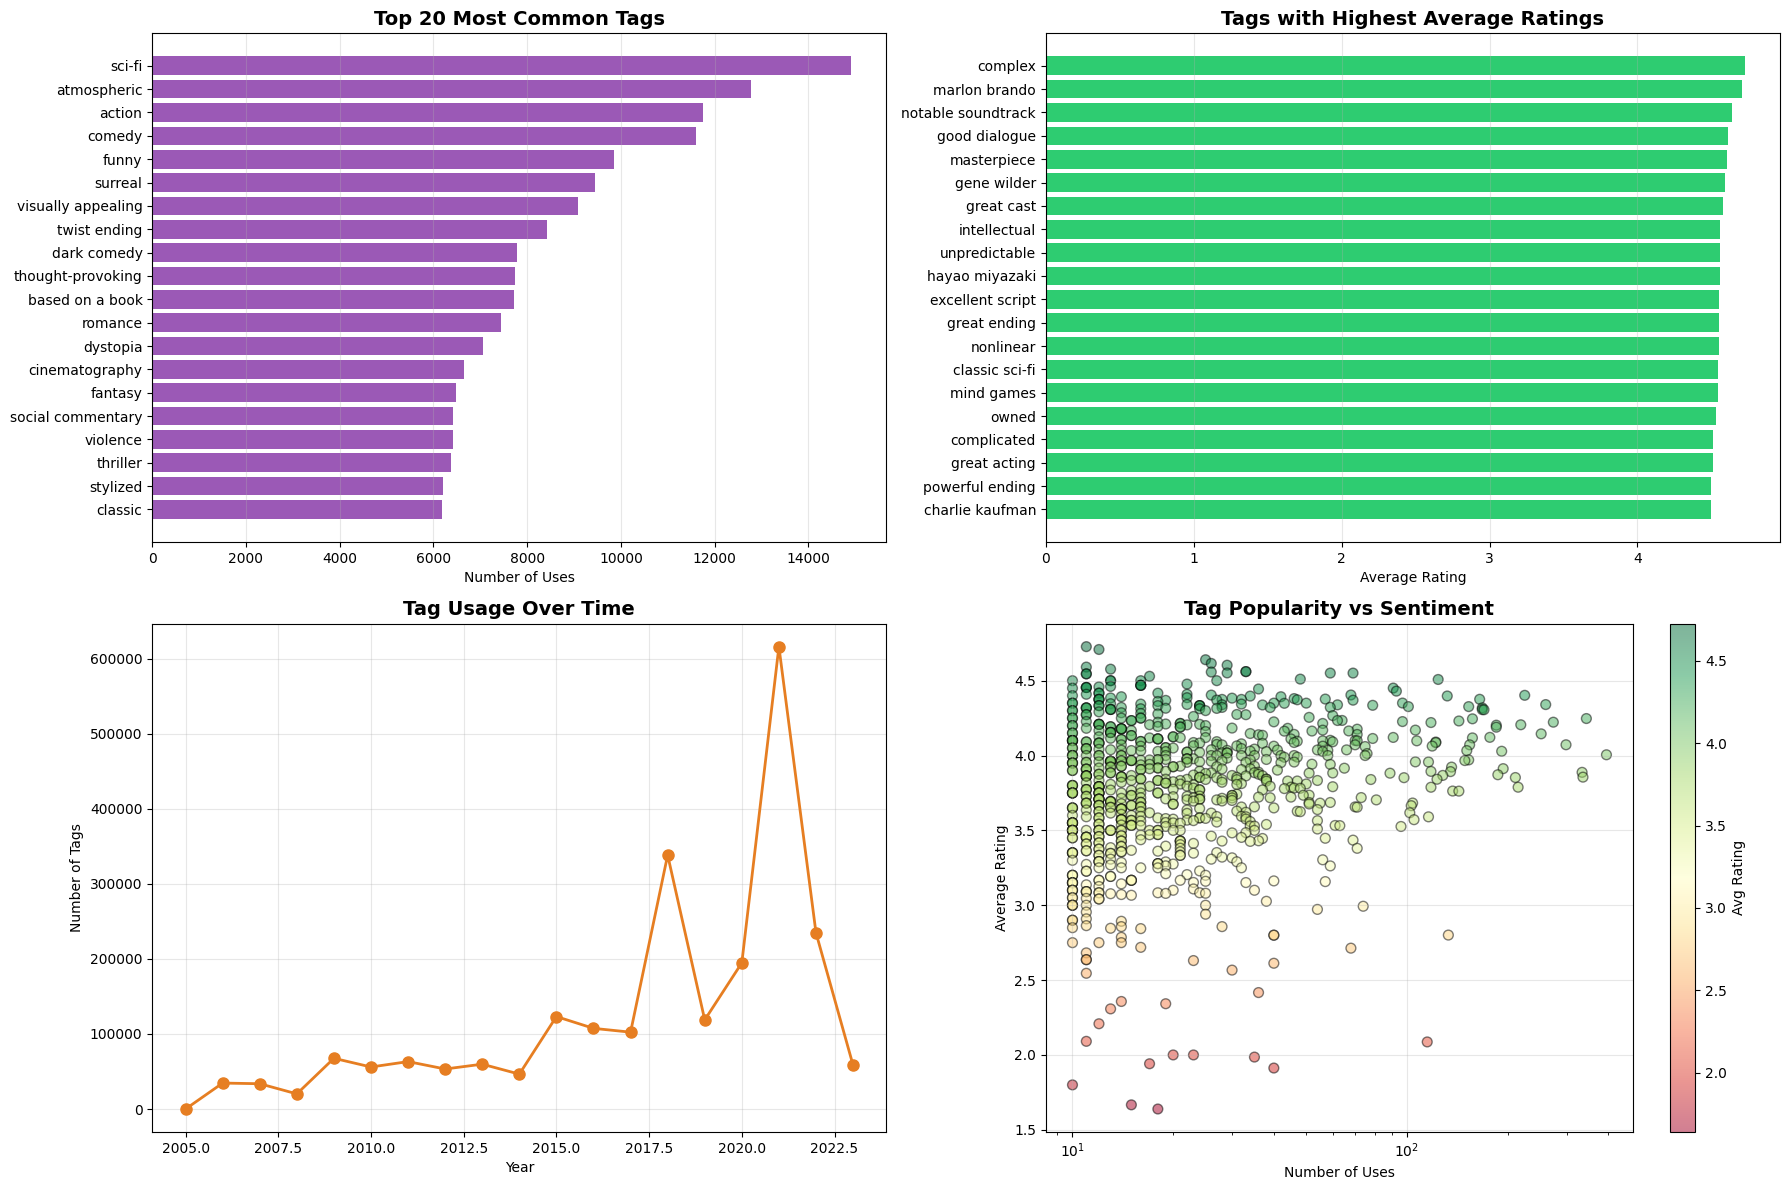

Chart saved as 'tag_analysis.png'


In [ ]:

print("TAG ANALYSIS")


# Clean tags (lowercase, strip whitespace)
tags['tag_clean'] = tags['tag'].str.lower().str.strip()

# Tag statistics
print("\n  TAG STATISTICS:")
print(f"   Total tag applications: {len(tags):,}")
print(f"   Unique tags (original): {tags['tag'].nunique():,}")
print(f"   Unique tags (cleaned): {tags['tag_clean'].nunique():,}")
print(f"   Users who tagged: {tags['userId'].nunique():,}")
print(f"   Movies with tags: {tags['movieId'].nunique():,}")

# Most common tags
tag_counts = tags['tag_clean'].value_counts()

print("\n Top 30 Most Used Tags:")
for i, (tag, count) in enumerate(tag_counts.head(30).items(), 1):
    pct = (count / len(tags)) * 100
    print(f"   {i:2d}. {tag:30s}: {count:>6,} uses ({pct:>5.2f}%)")

# Merge tags with ratings to see tag sentiment
tag_ratings = tags.merge(
    ratings[['userId', 'movieId', 'rating']],
    on=['userId', 'movieId'],
    how='left'
)

# Analyze tags by average rating
tag_rating_stats = tag_ratings.groupby('tag_clean').agg({
    'rating': ['count', 'mean', 'std'],
    'movieId': 'nunique',
    'userId': 'nunique'
}).reset_index()

tag_rating_stats.columns = ['tag', 'n_uses', 'avg_rating', 'rating_std',
                            'n_movies', 'n_users']

# Filter tags used at least 10 times
tag_rating_stats = tag_rating_stats[tag_rating_stats['n_uses'] >= 10]
tag_rating_stats = tag_rating_stats.sort_values('avg_rating', ascending=False)

print("\n Tags Associated with HIGHEST Rated Movies (min 10 uses):")
print(tag_rating_stats.head(20)[['tag', 'avg_rating', 'n_uses', 'n_movies']].to_string(index=False))

print("\n Tags Associated with LOWEST Rated Movies (min 10 uses):")
print(tag_rating_stats.tail(20)[['tag', 'avg_rating', 'n_uses', 'n_movies']].to_string(index=False))

# Visualize tags
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 20 most common tags
top_tags = tag_counts.head(20)
axes[0, 0].barh(range(len(top_tags)), top_tags.values, color='#9b59b6')
axes[0, 0].set_yticks(range(len(top_tags)))
axes[0, 0].set_yticklabels(top_tags.index)
axes[0, 0].set_xlabel('Number of Uses')
axes[0, 0].set_title('Top 20 Most Common Tags', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Tags by average rating (top 20 positive tags)
top_positive = tag_rating_stats.head(20)
axes[0, 1].barh(range(len(top_positive)), top_positive['avg_rating'], color='#2ecc71')
axes[0, 1].set_yticks(range(len(top_positive)))
axes[0, 1].set_yticklabels(top_positive['tag'])
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_title('Tags with Highest Average Ratings', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Tag usage over time
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')
tags['year'] = tags['timestamp'].dt.year
yearly_tags = tags.groupby('year').size()
axes[1, 0].plot(yearly_tags.index, yearly_tags.values, marker='o',
                linewidth=2, markersize=8, color='#e67e22')
axes[1, 0].set_title('Tag Usage Over Time', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Number of Tags')
axes[1, 0].grid(True, alpha=0.3)

# 4. Tag sentiment scatter (usage vs rating)
axes[1, 1].scatter(tag_rating_stats['n_uses'], tag_rating_stats['avg_rating'],
                   alpha=0.5, c=tag_rating_stats['avg_rating'],
                   cmap='RdYlGn', s=50, edgecolors='black')
axes[1, 1].set_xlabel('Number of Uses')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].set_title('Tag Popularity vs Sentiment', fontsize=14, fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Avg Rating')

plt.tight_layout()
plt.savefig('/content/tag_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'tag_analysis.png'")

# Movie Popularity Analysis

MOVIE POPULARITY ANALYSIS

  MOVIE STATISTICS:
   Total movies with ratings: 27,121
   Average ratings per movie: 36.8
   Median ratings per movie: 2
   Most rated movie: 3,584 ratings

 TOP 20 HIGHEST RATED MOVIES (min 100 ratings):
                                                                      title  avg_rating  n_ratings                                          genres
                                           Shawshank Redemption, The (1994)    4.428571       3584                                     Crime|Drama
                                                            Parasite (2019)    4.408505        388                                    Comedy|Drama
                                                      Godfather, The (1972)    4.347462       2206                                     Crime|Drama
                                                            Whiplash (2013)    4.308696        115                              (no genres listed)
                               

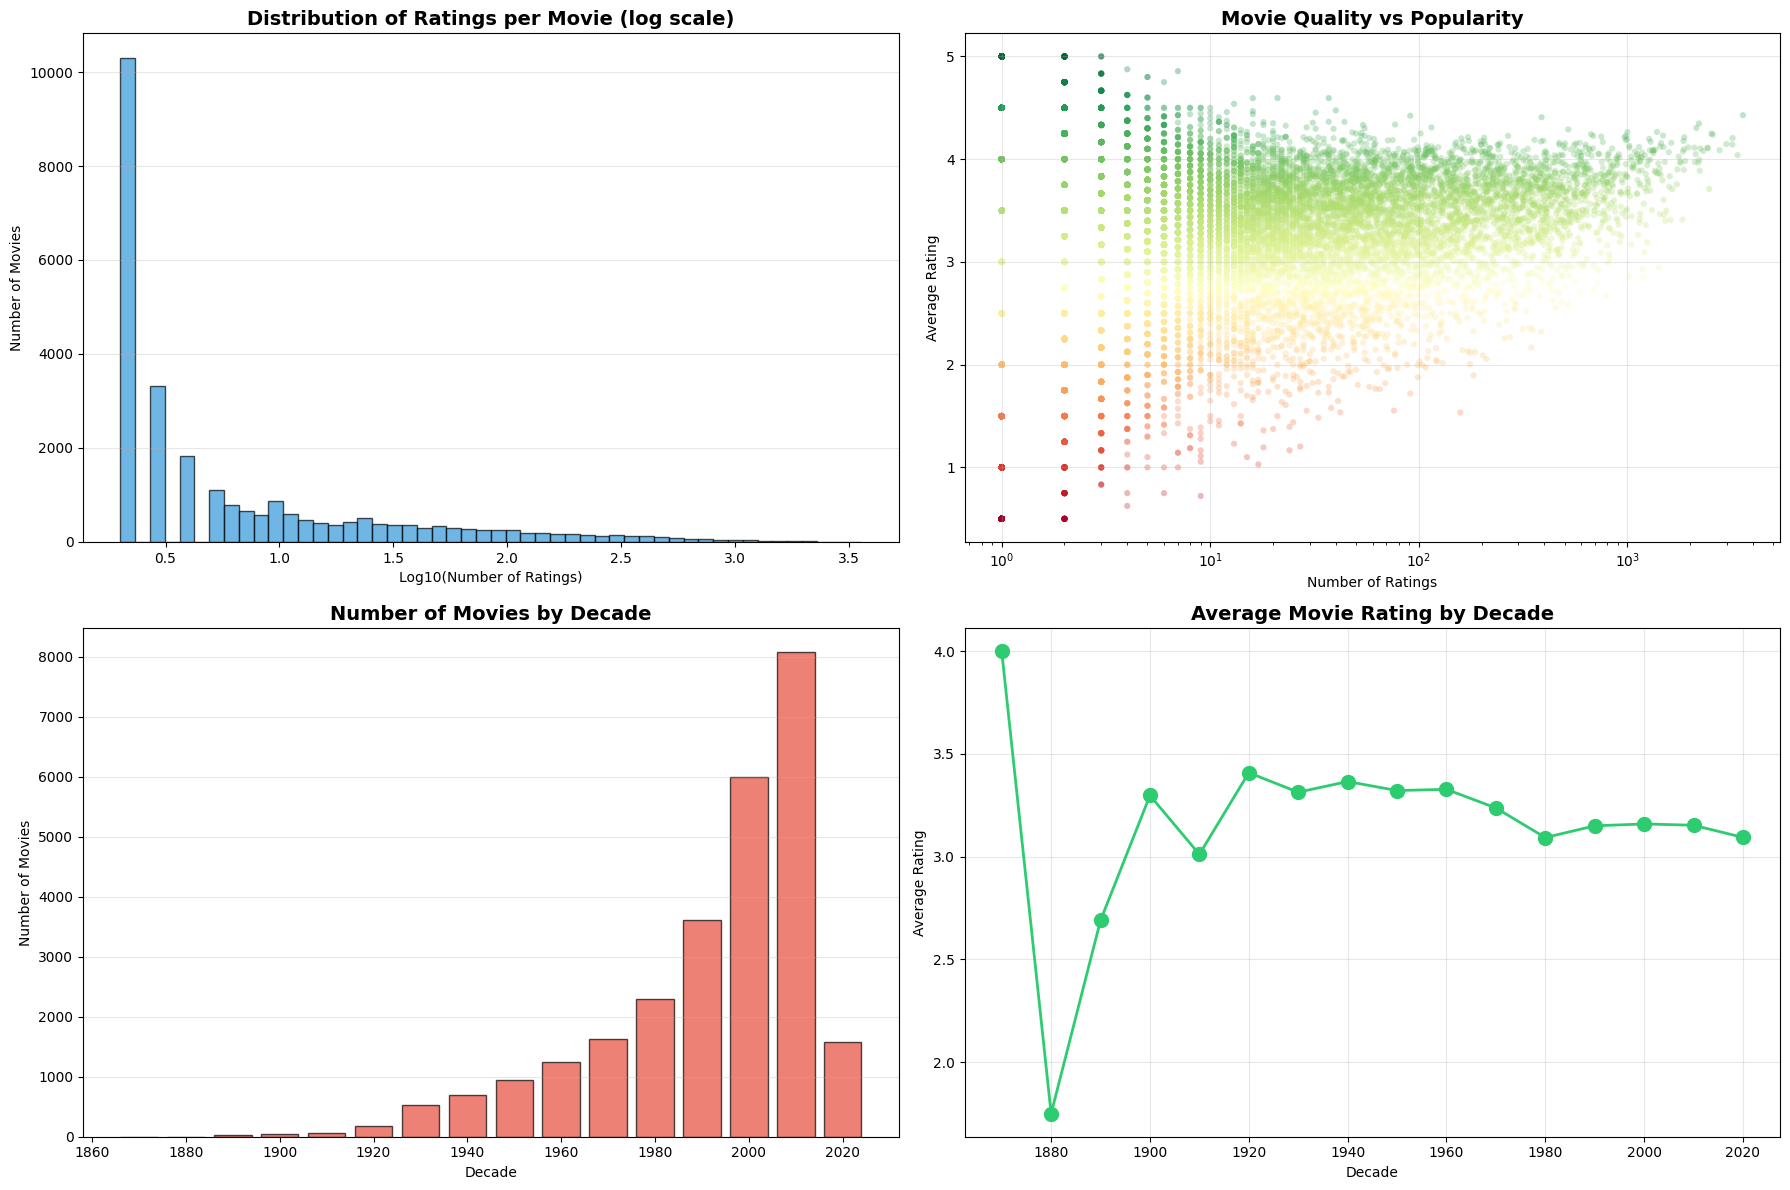

 Chart saved as 'movie_popularity_analysis.png'


In [ ]:

print("MOVIE POPULARITY ANALYSIS")


# Compute movie statistics
movie_stats = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean', 'std', 'median'],
    'userId': 'nunique',
    'timestamp': ['min', 'max']
}).reset_index()

movie_stats.columns = ['movieId', 'n_ratings', 'avg_rating', 'rating_std',
                       'median_rating', 'n_users', 'first_rated', 'last_rated']

# Merge with movie metadata
movie_stats = movie_stats.merge(
    movies[['movieId', 'title', 'genres', 'release_year', 'title_clean']],
    on='movieId'
)

# Calculate popularity metrics
movie_stats['rating_span_days'] = (movie_stats['last_rated'] -
                                   movie_stats['first_rated']).dt.days

# Weighted rating (IMDB formula)
C = ratings['rating'].mean()  # Mean rating across all movies
m = 50  # Minimum ratings required (can adjust)

def weighted_rating(row, C, m):
    v = row['n_ratings']
    R = row['avg_rating']
    return (v / (v + m) * R) + (m / (v + m) * C)

movie_stats['weighted_rating'] = movie_stats.apply(
    lambda row: weighted_rating(row, C, m), axis=1
)

print("\n  MOVIE STATISTICS:")
print(f"   Total movies with ratings: {len(movie_stats):,}")
print(f"   Average ratings per movie: {movie_stats['n_ratings'].mean():.1f}")
print(f"   Median ratings per movie: {movie_stats['n_ratings'].median():.0f}")
print(f"   Most rated movie: {movie_stats['n_ratings'].max():,} ratings")

# Top rated movies (with sufficient ratings)
popular_movies = movie_stats[movie_stats['n_ratings'] >= 100].copy()

print(f"\n TOP 20 HIGHEST RATED MOVIES (min 100 ratings):")
top_rated = popular_movies.nlargest(20, 'avg_rating')
print(top_rated[['title', 'avg_rating', 'n_ratings', 'genres']].to_string(index=False))

print(f"\n TOP 20 MOST POPULAR MOVIES (by number of ratings):")
most_popular = movie_stats.nlargest(20, 'n_ratings')
print(most_popular[['title', 'n_ratings', 'avg_rating', 'genres']].to_string(index=False))

print(f"\n TOP 20 BY WEIGHTED RATING (IMDB-style, min 50 ratings):")
top_weighted = movie_stats[movie_stats['n_ratings'] >= 50].nlargest(20, 'weighted_rating')
print(top_weighted[['title', 'weighted_rating', 'avg_rating', 'n_ratings']].to_string(index=False))

# Hidden gems: high rating, moderate visibility
print(f"\n HIDDEN GEMS (Avg rating ≥ 4.0, ratings between 50-200):")
hidden_gems = movie_stats[
    (movie_stats['avg_rating'] >= 4.0) &
    (movie_stats['n_ratings'] >= 50) &
    (movie_stats['n_ratings'] <= 200)
].sort_values('avg_rating', ascending=False).head(20)
print(hidden_gems[['title', 'avg_rating', 'n_ratings', 'genres']].to_string(index=False))

# Controversial movies: high rating variance
print(f"\n MOST CONTROVERSIAL MOVIES (highest rating std dev, min 100 ratings):")
controversial = movie_stats[movie_stats['n_ratings'] >= 100].nlargest(20, 'rating_std')
print(controversial[['title', 'avg_rating', 'rating_std', 'n_ratings']].to_string(index=False))

# Visualize movie popularity
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Distribution of ratings per movie
axes[0, 0].hist(np.log10(movie_stats['n_ratings'] + 1), bins=50,
                color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Ratings per Movie (log scale)',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Log10(Number of Ratings)')
axes[0, 0].set_ylabel('Number of Movies')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Average rating vs number of ratings
axes[0, 1].scatter(movie_stats['n_ratings'], movie_stats['avg_rating'],
                   alpha=0.3, s=20, c=movie_stats['avg_rating'],
                   cmap='RdYlGn', edgecolors='none')
axes[0, 1].set_xlabel('Number of Ratings')
axes[0, 1].set_ylabel('Average Rating')
axes[0, 1].set_title('Movie Quality vs Popularity', fontsize=14, fontweight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3. Movies by decade
movie_stats['decade'] = (movie_stats['release_year'] // 10 * 10).astype('Int64')
decade_counts = movie_stats['decade'].value_counts().sort_index()
axes[1, 0].bar(decade_counts.index, decade_counts.values,
               width=8, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Number of Movies by Decade', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Decade')
axes[1, 0].set_ylabel('Number of Movies')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Average rating by decade
decade_ratings = movie_stats.groupby('decade')['avg_rating'].mean()
axes[1, 1].plot(decade_ratings.index, decade_ratings.values,
                marker='o', linewidth=2, markersize=10, color='#2ecc71')
axes[1, 1].set_title('Average Movie Rating by Decade', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Decade')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/movie_popularity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


print(" Chart saved as 'movie_popularity_analysis.png'")

# Save movie stats
movie_stats.to_csv('/content/drive/MyDrive/MovieLens_Processed/movie_stats.csv', index=False)


## **Part B : Business Insights & Visual Analytics**






User Behavior Insights - Deep Dive

1️⃣  USER BEHAVIOR INSIGHTS

 A. HARSH vs GENEROUS RATERS PROFILE
--------------------------------------------------------------------------------

HARSH RATERS (18,570 users - 9.3%):
  • Average rating given: 1.87
  • Rating std dev: 1.17
  • Average movies rated: 3.0
  • Median movies rated: 1
  • Most prolific harsh rater: 237 ratings

MODERATE RATERS (64,279 users - 32.1%):
  • Average rating given: 3.18
  • Rating std dev: 0.97
  • Average movies rated: 6.7
  • Median movies rated: 3
  • Most prolific moderate rater: 960 ratings

GENEROUS RATERS (117,553 users - 58.7%):
  • Average rating given: 4.24
  • Rating std dev: 0.67
  • Average movies rated: 4.4
  • Median movies rated: 2
  • Most prolific generous rater: 187 ratings


 B. RATING EVOLUTION OVER TIME
--------------------------------------------------------------------------------

Rating trends over time:
  • Overall trend: STABLE (slope: 0.00017)
  • R-squared: 0.0382
  • Statistical significance (p-value): 3.5696e-04

Ye

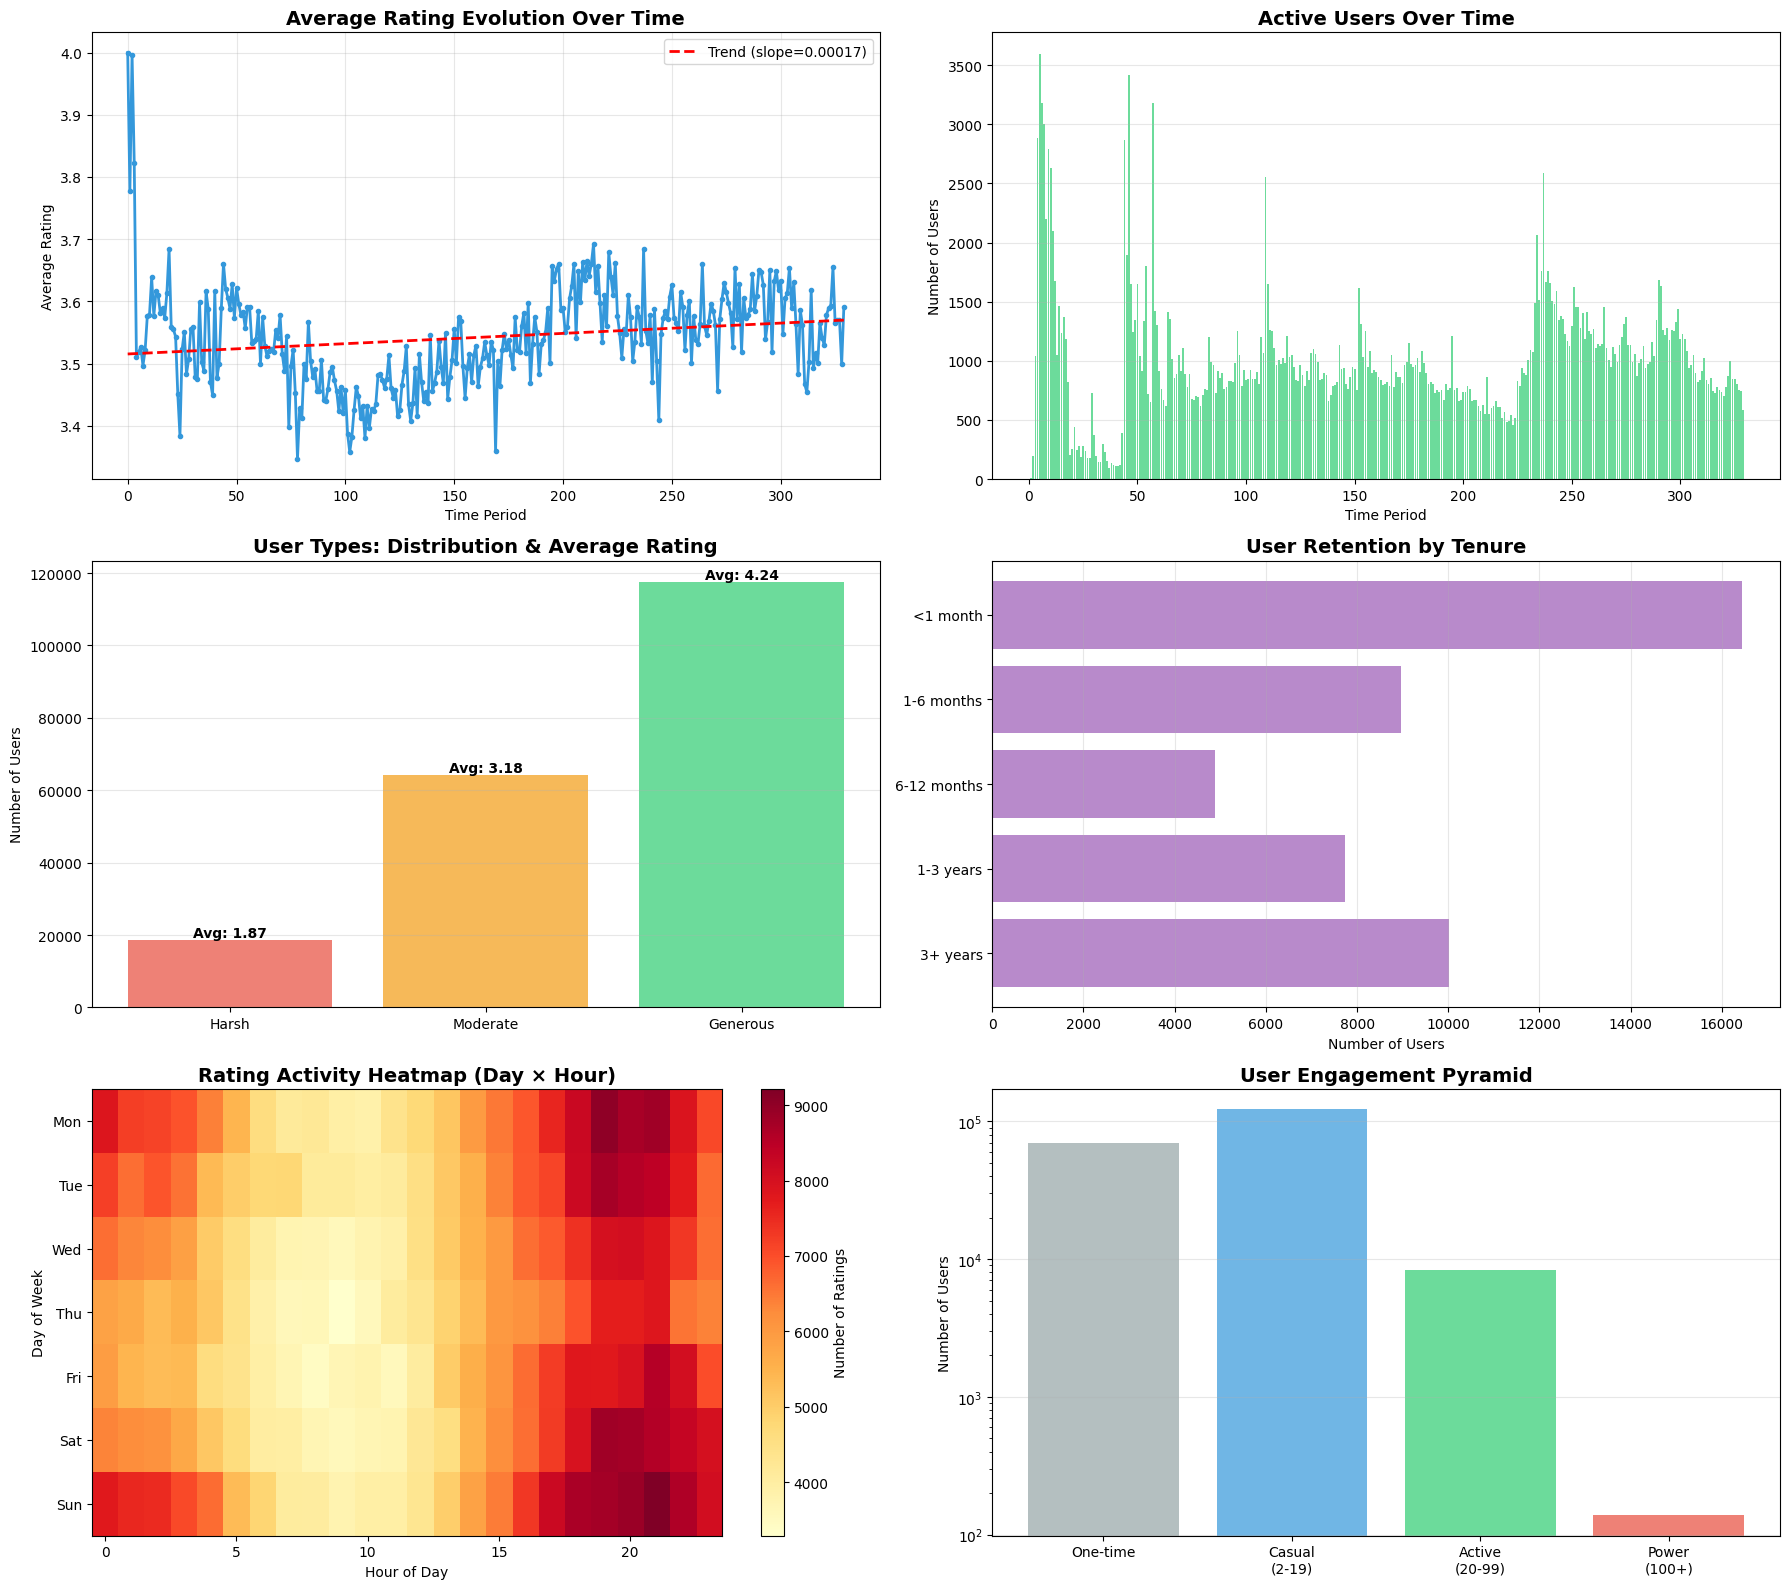

 Chart saved as 'user_behavior_insights.png'


In [ ]:

print("1️⃣  USER BEHAVIOR INSIGHTS")


# A. Harsh vs Generous Raters Analysis


print("\n A. HARSH vs GENEROUS RATERS PROFILE")
print("-"*80)

# Get detailed profiles for each user type
for bias_type in ['Harsh', 'Moderate', 'Generous']:
    bias_users = user_stats[user_stats['rating_bias'] == bias_type]

    if len(bias_users) > 0:
        print(f"\n{bias_type.upper()} RATERS ({len(bias_users):,} users - {len(bias_users)/len(user_stats)*100:.1f}%):")
        print(f"  • Average rating given: {bias_users['avg_rating'].mean():.2f}")
        print(f"  • Rating std dev: {bias_users['rating_std'].mean():.2f}")
        print(f"  • Average movies rated: {bias_users['n_ratings'].mean():.1f}")
        print(f"  • Median movies rated: {bias_users['n_ratings'].median():.0f}")
        print(f"  • Most prolific {bias_type.lower()} rater: {bias_users['n_ratings'].max()} ratings")


# B. Rating Evolution Over Time


print("\n\n B. RATING EVOLUTION OVER TIME")
print("-"*80)

# Monthly trends
ratings['year_month'] = ratings['timestamp'].dt.to_period('M')
monthly_trends = ratings.groupby('year_month').agg({
    'rating': ['mean', 'count'],
    'userId': 'nunique',
    'movieId': 'nunique'
}).reset_index()

monthly_trends.columns = ['year_month', 'avg_rating', 'n_ratings', 'n_users', 'n_movies']
monthly_trends['year_month'] = monthly_trends['year_month'].astype(str)

print(f"\nRating trends over time:")
print(f"  • Overall trend: ", end="")

# Calculate trend
from scipy import stats
x = np.arange(len(monthly_trends))
y = monthly_trends['avg_rating'].values
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

if slope > 0.001:
    print(f"INCREASING (slope: {slope:.5f})")
elif slope < -0.001:
    print(f"DECREASING (slope: {slope:.5f})")
else:
    print(f"STABLE (slope: {slope:.5f})")

print(f"  • R-squared: {r_value**2:.4f}")
print(f"  • Statistical significance (p-value): {p_value:.4e}")

# Year-over-year comparison
yearly_comparison = ratings.groupby('year').agg({
    'rating': ['mean', 'std'],
    'userId': 'nunique'
}).reset_index()
yearly_comparison.columns = ['year', 'avg_rating', 'rating_std', 'n_users']

print(f"\nYear-over-Year Analysis:")
for idx, row in yearly_comparison.tail(5).iterrows():
    print(f"  {int(row['year'])}: Avg rating = {row['avg_rating']:.3f}, "
          f"Active users = {row['n_users']:,}, Std dev = {row['rating_std']:.3f}")


# C. User Retention Analysis


print("\n\n C. USER RETENTION & ENGAGEMENT ANALYSIS")
print("-"*80)

# User lifecycle analysis
user_stats['is_active_user'] = user_stats['n_ratings'] >= 20
user_stats['is_power_user'] = user_stats['n_ratings'] >= 100

print(f"\nUser Engagement Tiers:")
print(f"  • One-time raters: {(user_stats['n_ratings'] == 1).sum():,} ({(user_stats['n_ratings'] == 1).sum()/len(user_stats)*100:.1f}%)")
print(f"  • Casual users (2-19 ratings): {((user_stats['n_ratings'] >= 2) & (user_stats['n_ratings'] < 20)).sum():,}")
print(f"  • Active users (20-99 ratings): {((user_stats['n_ratings'] >= 20) & (user_stats['n_ratings'] < 100)).sum():,}")
print(f"  • Power users (100+ ratings): {(user_stats['n_ratings'] >= 100).sum():,}")

# User tenure analysis
print(f"\nUser Tenure Analysis:")
print(f"  • Users active < 1 month: {(user_stats['tenure_days'] < 30).sum():,}")
print(f"  • Users active 1-6 months: {((user_stats['tenure_days'] >= 30) & (user_stats['tenure_days'] < 180)).sum():,}")
print(f"  • Users active 6-12 months: {((user_stats['tenure_days'] >= 180) & (user_stats['tenure_days'] < 365)).sum():,}")
print(f"  • Users active 1+ years: {(user_stats['tenure_days'] >= 365).sum():,}")
print(f"  • Average tenure: {user_stats['tenure_days'].mean():.0f} days")

# Engagement rate over time
print(f"\nEngagement Metrics:")
engaged_users = user_stats[user_stats['tenure_days'] > 0]
print(f"  • Average ratings per day (active users): {engaged_users['ratings_per_day'].mean():.3f}")
print(f"  • Median ratings per day (active users): {engaged_users['ratings_per_day'].median():.3f}")

# Identify highly engaged users
highly_engaged = user_stats[user_stats['ratings_per_day'] > 1]
print(f"  • Highly engaged users (>1 rating/day): {len(highly_engaged):,} ({len(highly_engaged)/len(user_stats)*100:.2f}%)")

# Visualizations
fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# 1. Rating evolution over time
axes[0, 0].plot(range(len(monthly_trends)), monthly_trends['avg_rating'],
                linewidth=2, color='#3498db', marker='o', markersize=3)
axes[0, 0].plot(x, intercept + slope * x, 'r--', linewidth=2,
                label=f'Trend (slope={slope:.5f})')
axes[0, 0].set_title('Average Rating Evolution Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time Period')
axes[0, 0].set_ylabel('Average Rating')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Number of active users over time
axes[0, 1].bar(range(len(monthly_trends)), monthly_trends['n_users'],
               color='#2ecc71', alpha=0.7)
axes[0, 1].set_title('Active Users Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Time Period')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. User type distribution with detailed stats
user_type_data = []
for bias in ['Harsh', 'Moderate', 'Generous']:
    count = len(user_stats[user_stats['rating_bias'] == bias])
    avg_rating = user_stats[user_stats['rating_bias'] == bias]['avg_rating'].mean()
    user_type_data.append((bias, count, avg_rating))

x_pos = range(len(user_type_data))
colors_bias = ['#e74c3c', '#f39c12', '#2ecc71']
axes[1, 0].bar(x_pos, [d[1] for d in user_type_data], color=colors_bias, alpha=0.7)
axes[1, 0].set_title('User Types: Distribution & Average Rating', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([d[0] for d in user_type_data])
axes[1, 0].set_ylabel('Number of Users')

# Add average rating as text
for i, (bias, count, avg) in enumerate(user_type_data):
    axes[1, 0].text(i, count, f'Avg: {avg:.2f}',
                    ha='center', va='bottom', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. User retention cohort
tenure_bins = [0, 30, 180, 365, 1000, 10000]
tenure_labels = ['<1 month', '1-6 months', '6-12 months', '1-3 years', '3+ years']
user_stats['tenure_category'] = pd.cut(user_stats['tenure_days'],
                                        bins=tenure_bins,
                                        labels=tenure_labels)
tenure_dist = user_stats['tenure_category'].value_counts().sort_index()

axes[1, 1].barh(range(len(tenure_dist)), tenure_dist.values, color='#9b59b6', alpha=0.7)
axes[1, 1].set_yticks(range(len(tenure_dist)))
axes[1, 1].set_yticklabels(tenure_dist.index)
axes[1, 1].set_title('User Retention by Tenure', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Users')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

# 5. Rating activity heatmap by day and hour
day_hour_activity = ratings.groupby(['day_of_week', 'hour']).size().reset_index(name='count')
pivot_activity = day_hour_activity.pivot(index='day_of_week', columns='hour', values='count')
pivot_activity = pivot_activity.fillna(0)

im = axes[2, 0].imshow(pivot_activity, cmap='YlOrRd', aspect='auto')
axes[2, 0].set_title('Rating Activity Heatmap (Day × Hour)', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Hour of Day')
axes[2, 0].set_ylabel('Day of Week')
axes[2, 0].set_yticks(range(7))
axes[2, 0].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.colorbar(im, ax=axes[2, 0], label='Number of Ratings')

# 6. User engagement segments
engagement_categories = ['One-time', 'Casual\n(2-19)', 'Active\n(20-99)', 'Power\n(100+)']
engagement_counts = [
    (user_stats['n_ratings'] == 1).sum(),
    ((user_stats['n_ratings'] >= 2) & (user_stats['n_ratings'] < 20)).sum(),
    ((user_stats['n_ratings'] >= 20) & (user_stats['n_ratings'] < 100)).sum(),
    (user_stats['n_ratings'] >= 100).sum()
]

axes[2, 1].bar(range(len(engagement_counts)), engagement_counts,
               color=['#95a5a6', '#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
axes[2, 1].set_title('User Engagement Pyramid', fontsize=14, fontweight='bold')
axes[2, 1].set_xticks(range(len(engagement_categories)))
axes[2, 1].set_xticklabels(engagement_categories)
axes[2, 1].set_ylabel('Number of Users')
axes[2, 1].set_yscale('log')
axes[2, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/user_behavior_insights.png', dpi=300, bbox_inches='tight')
plt.show()


print(" Chart saved as 'user_behavior_insights.png'")

Content Insights - Strategic Analysis

2️⃣  CONTENT INSIGHTS FOR STRATEGY

 A. GENRE PERFORMANCE: BEST vs WORST
--------------------------------------------------------------------------------

 BEST PERFORMING GENRES (min 1000 ratings):
  Film-Noir      : Avg rating = 3.920,   9,491 ratings,   225 movies
  War            : Avg rating = 3.796,  50,070 ratings,   951 movies
  Documentary    : Avg rating = 3.699,  13,060 ratings, 2,045 movies
  Crime          : Avg rating = 3.697, 168,663 ratings, 2,748 movies
  Drama          : Avg rating = 3.684, 437,072 ratings, 12,178 movies

 WORST PERFORMING GENRES (min 1000 ratings):
  Sci-Fi         : Avg rating = 3.496, 177,969 ratings, 2,057 movies
  Action         : Avg rating = 3.479, 301,201 ratings, 3,731 movies
  Children       : Avg rating = 3.434,  85,505 ratings, 1,561 movies
  Comedy         : Avg rating = 3.430, 349,461 ratings, 8,426 movies
  Horror         : Avg rating = 3.307,  77,274 ratings, 2,941 movies

 GENRE CONSISTENCY (Rating Std Dev):

Most Consistent Genres (l

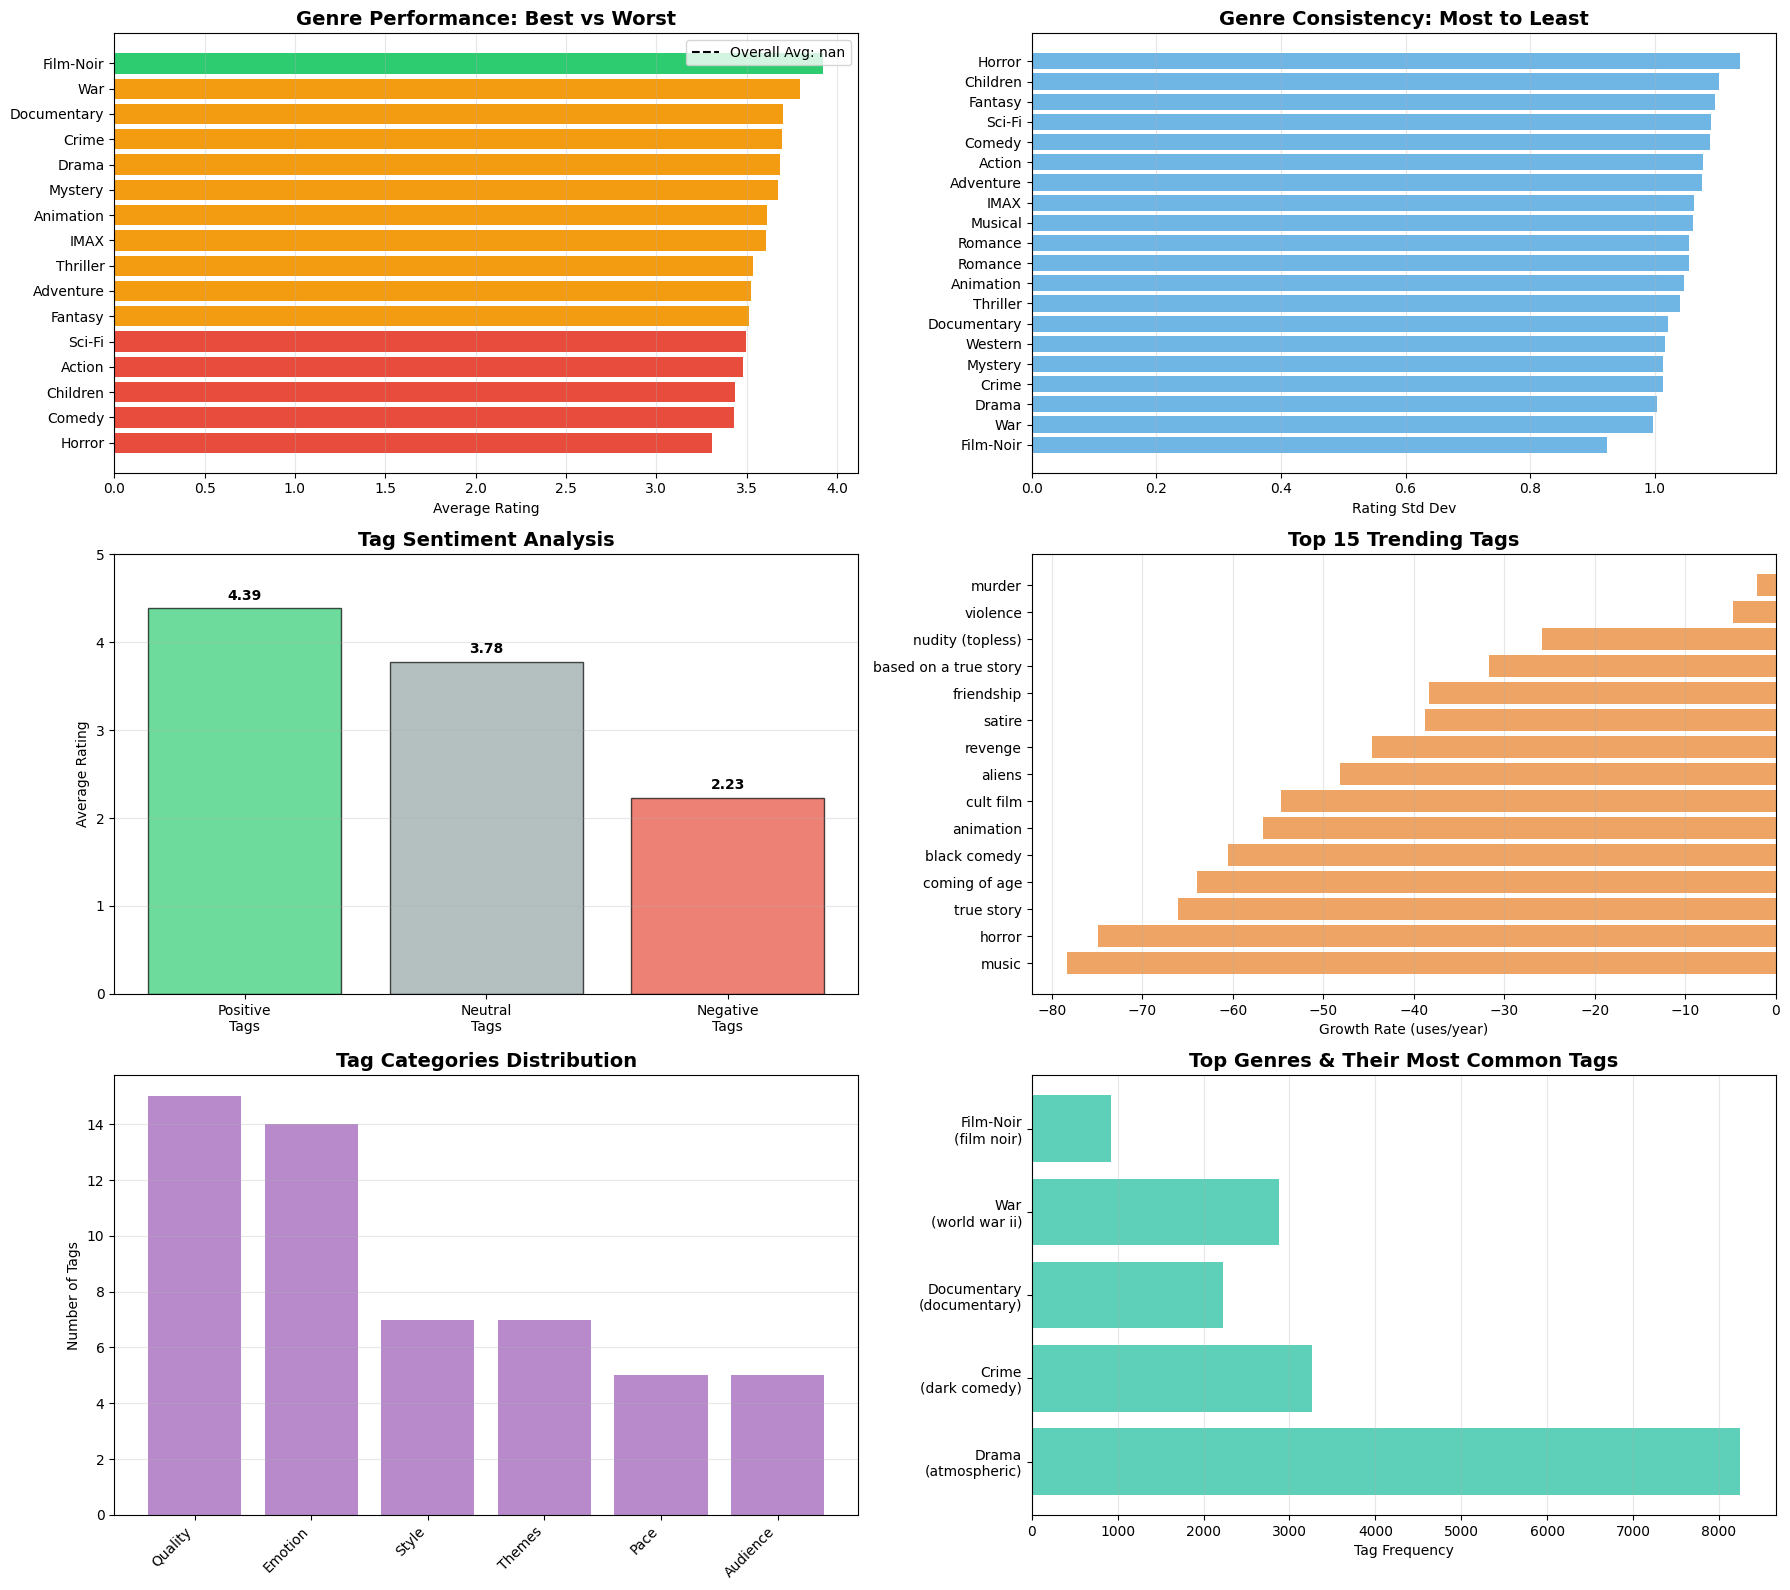

 Chart saved as 'content_insights.png'


In [ ]:



print("2️⃣  CONTENT INSIGHTS FOR STRATEGY")



# A. Genre Performance Analysis


print("\n A. GENRE PERFORMANCE: BEST vs WORST")
print("-"*80)

# Filter genres with sufficient data
significant_genres = genre_stats[genre_stats['n_ratings'] >= 1000].copy()

print(f"\n BEST PERFORMING GENRES (min 1000 ratings):")
best_genres = significant_genres.head(5)
for idx, row in best_genres.iterrows():
    print(f"  {row['genre']:15s}: Avg rating = {row['avg_rating']:.3f}, "
          f"{row['n_ratings']:>7,} ratings, {row['n_movies']:>5,} movies")

print(f"\n WORST PERFORMING GENRES (min 1000 ratings):")
worst_genres = significant_genres.tail(5)
for idx, row in worst_genres.iterrows():
    print(f"  {row['genre']:15s}: Avg rating = {row['avg_rating']:.3f}, "
          f"{row['n_ratings']:>7,} ratings, {row['n_movies']:>5,} movies")

# Genre consistency analysis
print(f"\n GENRE CONSISTENCY (Rating Std Dev):")
genre_consistency = significant_genres.sort_values('rating_std')
print(f"\nMost Consistent Genres (low variance):")
for idx, row in genre_consistency.head(5).iterrows():
    print(f"  {row['genre']:15s}: Std dev = {row['rating_std']:.3f}")

print(f"\nMost Polarizing Genres (high variance):")
for idx, row in genre_consistency.tail(5).iterrows():
    print(f"  {row['genre']:15s}: Std dev = {row['rating_std']:.3f}")


# B. Tag-Driven Analytics


print("\n\n  B. TAG-DRIVEN ANALYTICS")
print("-"*80)

# Sentiment tags analysis
positive_keywords = ['excellent', 'amazing', 'great', 'perfect', 'brilliant',
                     'outstanding', 'masterpiece', 'beautiful', 'wonderful', 'fantastic']
negative_keywords = ['bad', 'awful', 'terrible', 'boring', 'worst', 'disappointing',
                     'waste', 'horrible', 'poor', 'dull']

tag_rating_stats['is_positive'] = tag_rating_stats['tag'].apply(
    lambda x: any(word in x for word in positive_keywords)
)
tag_rating_stats['is_negative'] = tag_rating_stats['tag'].apply(
    lambda x: any(word in x for word in negative_keywords)
)

positive_tags = tag_rating_stats[tag_rating_stats['is_positive']]
negative_tags = tag_rating_stats[tag_rating_stats['is_negative']]

print(f"\n POSITIVE SENTIMENT TAGS:")
print(f"  • Number of positive tags: {len(positive_tags)}")
print(f"  • Average rating for positive tags: {positive_tags['avg_rating'].mean():.3f}")
print(f"\n  Top positive tags:")
for idx, row in positive_tags.nlargest(10, 'n_uses').iterrows():
    print(f"    {row['tag']:30s}: {row['n_uses']:>5,} uses, avg rating = {row['avg_rating']:.2f}")

print(f"\n NEGATIVE SENTIMENT TAGS:")
print(f"  • Number of negative tags: {len(negative_tags)}")
print(f"  • Average rating for negative tags: {negative_tags['avg_rating'].mean():.3f}")
print(f"\n  Top negative tags:")
for idx, row in negative_tags.nlargest(10, 'n_uses').iterrows():
    print(f"    {row['tag']:30s}: {row['n_uses']:>5,} uses, avg rating = {row['avg_rating']:.2f}")

# Trending tags (tags with increasing usage over time)
print(f"\n\n TRENDING TAGS (Usage Growth Analysis):")

# Analyze tag growth over recent years
recent_years = sorted(tags['year'].unique())[-5:]  # Last 5 years
tag_trends = []

for tag in tag_counts.head(50).index:  # Analyze top 50 tags
    tag_data = tags[tags['tag_clean'] == tag]
    yearly_counts = tag_data.groupby('year').size()

    if len(yearly_counts) >= 3:  # Need at least 3 years of data
        recent_counts = yearly_counts[yearly_counts.index.isin(recent_years)]
        if len(recent_counts) >= 3:
            # Calculate growth rate
            x = np.arange(len(recent_counts))
            y = recent_counts.values
            if len(x) > 1 and y.sum() > 0:
                slope, _, _, _, _ = stats.linregress(x, y)
                tag_trends.append({
                    'tag': tag,
                    'growth_rate': slope,
                    'recent_usage': recent_counts.sum()
                })

trend_df = pd.DataFrame(tag_trends).sort_values('growth_rate', ascending=False)

print(f"\n  Top 10 Growing Tags:")
for idx, row in trend_df.head(10).iterrows():
    print(f"    {row['tag']:30s}: Growth rate = {row['growth_rate']:>6.1f} uses/year, "
          f"Recent usage = {row['recent_usage']:.0f}")

print(f"\n  Top 10 Declining Tags:")
for idx, row in trend_df.tail(10).iterrows():
    print(f"    {row['tag']:30s}: Growth rate = {row['growth_rate']:>6.1f} uses/year, "
          f"Recent usage = {row['recent_usage']:.0f}")


# C. Tag Clusters Analysis


print(f"\n\n C. TAG CLUSTERS & THEMES")
print("-"*80)

# Define tag categories
tag_categories = {
    'Quality': ['excellent', 'great', 'amazing', 'perfect', 'masterpiece',
                'brilliant', 'outstanding', 'beautiful'],
    'Emotion': ['funny', 'sad', 'scary', 'romantic', 'dark', 'emotional',
                'intense', 'heartwarming'],
    'Style': ['artsy', 'atmospheric', 'surreal', 'quirky', 'stylish',
              'visually stunning', 'cerebral'],
    'Pace': ['slow', 'fast paced', 'action packed', 'suspenseful', 'engaging'],
    'Themes': ['political', 'psychological', 'philosophical', 'historical',
               'social commentary', 'thought-provoking'],
    'Audience': ['cult classic', 'underrated', 'overrated', 'classic',
                 'must see', 'hidden gem']
}

print(f"\nTag Category Analysis:")
for category, keywords in tag_categories.items():
    category_tags = tag_rating_stats[
        tag_rating_stats['tag'].apply(lambda x: any(word in x for word in keywords))
    ]

    if len(category_tags) > 0:
        print(f"\n  {category.upper()}:")
        print(f"    • Number of tags: {len(category_tags)}")
        print(f"    • Total uses: {category_tags['n_uses'].sum():,}")
        print(f"    • Average rating: {category_tags['avg_rating'].mean():.3f}")
        print(f"    • Most used: {category_tags.nlargest(3, 'n_uses')['tag'].tolist()}")

# Visualizations
fig, axes = plt.subplots(3, 2, figsize=(18, 16))

# 1. Best vs Worst Genres
comparison_genres = pd.concat([
    significant_genres.head(8),
    significant_genres.tail(8)
]).sort_values('avg_rating', ascending=True)

colors = ['#e74c3c' if x < 3.5 else '#f39c12' if x < 3.8 else '#2ecc71'
          for x in comparison_genres['avg_rating']]

axes[0, 0].barh(range(len(comparison_genres)), comparison_genres['avg_rating'], color=colors)
axes[0, 0].set_yticks(range(len(comparison_genres)))
axes[0, 0].set_yticklabels(comparison_genres['genre'])
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_title('Genre Performance: Best vs Worst', fontsize=14, fontweight='bold')
axes[0, 0].axvline(x=ratings['rating'].mean(), color='black', linestyle='--',
                   label=f'Overall Avg: {ratings["rating"].mean():.2f}')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Genre Consistency (Std Dev)
consistency_comp = pd.concat([
    genre_consistency.head(10),
    genre_consistency.tail(10)
]).sort_values('rating_std')

axes[0, 1].barh(range(len(consistency_comp)), consistency_comp['rating_std'],
                color='#3498db', alpha=0.7)
axes[0, 1].set_yticks(range(len(consistency_comp)))
axes[0, 1].set_yticklabels(consistency_comp['genre'])
axes[0, 1].set_xlabel('Rating Std Dev')
axes[0, 1].set_title('Genre Consistency: Most to Least', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Positive vs Negative Tag Sentiment
sentiment_data = [
    positive_tags['avg_rating'].mean(),
    tag_rating_stats[~(tag_rating_stats['is_positive'] | tag_rating_stats['is_negative'])]['avg_rating'].mean(),
    negative_tags['avg_rating'].mean()
]
sentiment_labels = ['Positive\nTags', 'Neutral\nTags', 'Negative\nTags']
sentiment_colors = ['#2ecc71', '#95a5a6', '#e74c3c']

axes[1, 0].bar(range(len(sentiment_data)), sentiment_data,
               color=sentiment_colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_xticks(range(len(sentiment_labels)))
axes[1, 0].set_xticklabels(sentiment_labels)
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].set_title('Tag Sentiment Analysis', fontsize=14, fontweight='bold')
axes[1, 0].set_ylim([0, 5])
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(sentiment_data):
    axes[1, 0].text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

# 4. Trending Tags
if len(trend_df) > 0:
    top_trends = trend_df.head(15)
    axes[1, 1].barh(range(len(top_trends)), top_trends['growth_rate'], color='#e67e22', alpha=0.7)
    axes[1, 1].set_yticks(range(len(top_trends)))
    axes[1, 1].set_yticklabels(top_trends['tag'])
    axes[1, 1].set_xlabel('Growth Rate (uses/year)')
    axes[1, 1].set_title('Top 15 Trending Tags', fontsize=14, fontweight='bold')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(axis='x', alpha=0.3)

# 5. Tag Category Distribution
category_data = []
for category, keywords in tag_categories.items():
    category_tags = tag_rating_stats[
        tag_rating_stats['tag'].apply(lambda x: any(word in x for word in keywords))
    ]
    if len(category_tags) > 0:
        category_data.append({
            'category': category,
            'count': len(category_tags),
            'avg_rating': category_tags['avg_rating'].mean()
        })

if category_data:
    cat_df = pd.DataFrame(category_data).sort_values('count', ascending=False)

    axes[2, 0].bar(range(len(cat_df)), cat_df['count'], color='#9b59b6', alpha=0.7)
    axes[2, 0].set_xticks(range(len(cat_df)))
    axes[2, 0].set_xticklabels(cat_df['category'], rotation=45, ha='right')
    axes[2, 0].set_ylabel('Number of Tags')
    axes[2, 0].set_title('Tag Categories Distribution', fontsize=14, fontweight='bold')
    axes[2, 0].grid(axis='y', alpha=0.3)

# 6. Genre-Tag Relationship (sample)
# Get top 5 genres and their most common tags
top_5_genres = genre_stats.head(5)['genre'].tolist()

genre_tag_data = []
for genre in top_5_genres:
    genre_movies = movies[movies['genres'].str.contains(genre, na=False)]['movieId']
    genre_tags = tags[tags['movieId'].isin(genre_movies)]

    if len(genre_tags) > 0:
        top_tag = genre_tags['tag_clean'].value_counts().head(1)
        if len(top_tag) > 0:
            genre_tag_data.append({
                'genre': genre,
                'top_tag': top_tag.index[0],
                'count': top_tag.values[0]
            })

if genre_tag_data:
    gt_df = pd.DataFrame(genre_tag_data)
    axes[2, 1].barh(range(len(gt_df)), gt_df['count'], color='#1abc9c', alpha=0.7)
    axes[2, 1].set_yticks(range(len(gt_df)))
    axes[2, 1].set_yticklabels([f"{row['genre']}\n({row['top_tag']})"
                                 for _, row in gt_df.iterrows()])
    axes[2, 1].set_xlabel('Tag Frequency')
    axes[2, 1].set_title('Top Genres & Their Most Common Tags', fontsize=14, fontweight='bold')
    axes[2, 1].invert_yaxis()
    axes[2, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/content_insights.png', dpi=300, bbox_inches='tight')
plt.show()


print(" Chart saved as 'content_insights.png'")

Hidden Patterns - Strategic Discovery

3️⃣  HIDDEN PATTERNS & STRATEGIC INSIGHTS

 A. IMPACT OF RELEASE YEAR ON RATINGS
--------------------------------------------------------------------------------

 Movie Performance by Decade:

Decade     Avg Rating   # Movies     Total Ratings   Avg Ratings/Movie
----------------------------------------------------------------------
1890       2.690        35           42              1.2         
1900       3.298        45           84              1.9         
1910       3.012        68           126             1.9         
1920       3.409        185          1,516           8.2         
1930       3.314        528          7,165           13.6        
1940       3.366        688          11,257          16.4        
1950       3.322        940          19,044          20.3        
1960       3.328        1,252        27,376          21.9        
1970       3.237        1,634        48,690          29.8        
1980       3.093        2,301        119,303         51.8        
1990

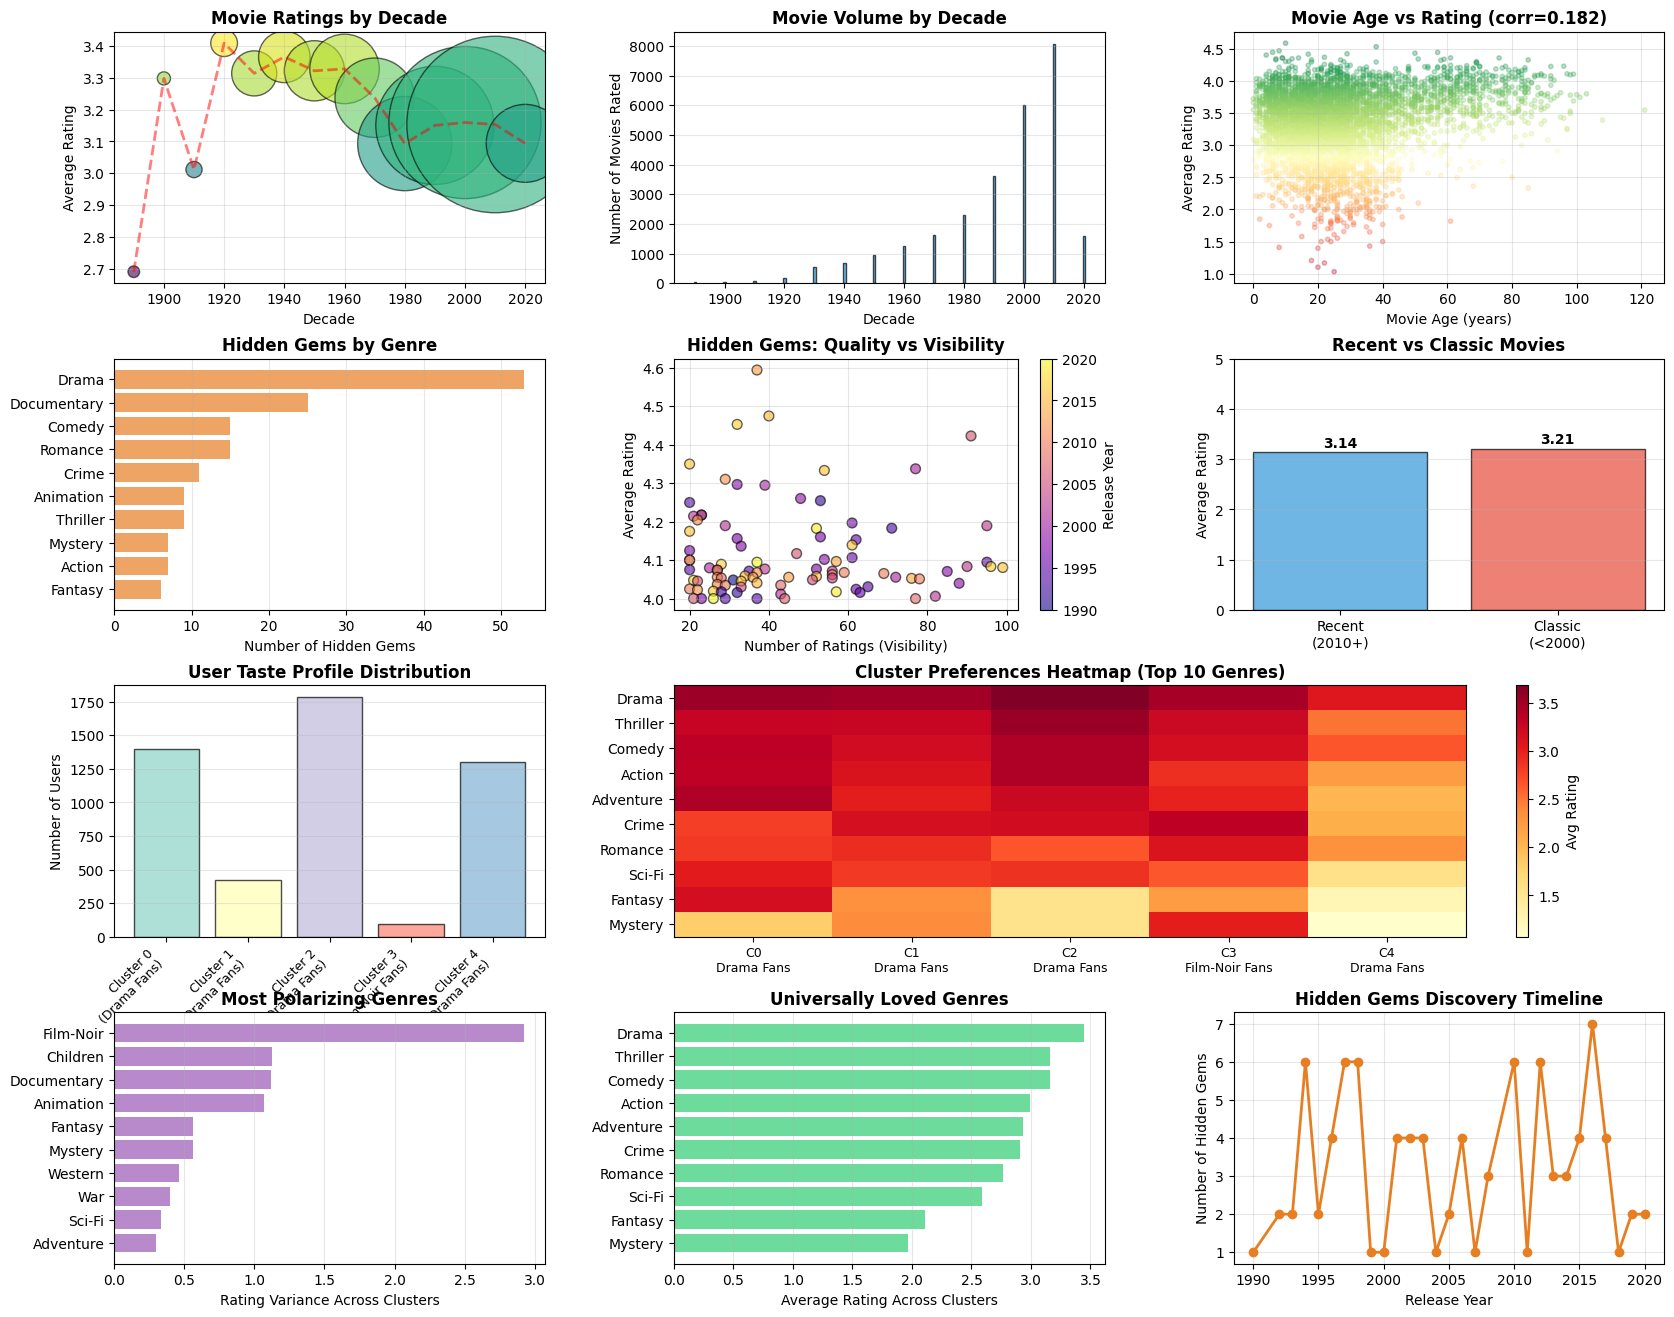

Chart saved as 'hidden_patterns_analysis.png'


In [ ]:




print("3️⃣  HIDDEN PATTERNS & STRATEGIC INSIGHTS")


# A. Impact of Release Year on Ratings


print("\n A. IMPACT OF RELEASE YEAR ON RATINGS")
print("-"*80)

# Decade analysis
movie_stats['decade'] = (movie_stats['release_year'] // 10 * 10).astype('Int64')

decade_analysis = movie_stats.groupby('decade').agg({
    'avg_rating': ['mean', 'std', 'count'],
    'n_ratings': ['sum', 'mean'],
    'movieId': 'count'
}).reset_index()

decade_analysis.columns = ['decade', 'avg_rating_mean', 'avg_rating_std', 'n_movies_rated',
                           'total_ratings', 'avg_ratings_per_movie', 'n_movies']

# Filter decades with sufficient data
significant_decades = decade_analysis[decade_analysis['n_movies_rated'] >= 10]

print(f"\n Movie Performance by Decade:")
print(f"\n{'Decade':<10} {'Avg Rating':<12} {'# Movies':<12} {'Total Ratings':<15} {'Avg Ratings/Movie'}")
print("-" * 70)
for idx, row in significant_decades.iterrows():
    if pd.notna(row['decade']):
        print(f"{int(row['decade']):<10} {row['avg_rating_mean']:<12.3f} "
              f"{row['n_movies_rated']:<12,} {row['total_ratings']:<15,} "
              f"{row['avg_ratings_per_movie']:<12.1f}")

# Find "golden era" (highest rated decade)
golden_era = significant_decades.loc[significant_decades['avg_rating_mean'].idxmax()]
print(f"\n🏆 'GOLDEN ERA' of Cinema (by ratings): {int(golden_era['decade'])}s")
print(f"   Average rating: {golden_era['avg_rating_mean']:.3f}")
print(f"   Movies from this era: {golden_era['n_movies_rated']:,}")

# Find most popular era (most ratings)
popular_era = significant_decades.loc[significant_decades['total_ratings'].idxmax()]
print(f"\n MOST POPULAR ERA (by volume): {int(popular_era['decade'])}s")
print(f"   Total ratings: {popular_era['total_ratings']:,}")
print(f"   Movies: {popular_era['n_movies_rated']:,}")

# Recent vs Classic movies comparison
recent_movies = movie_stats[movie_stats['release_year'] >= 2010]
classic_movies = movie_stats[movie_stats['release_year'] < 2000]

print(f"\n RECENT (2010+) vs CLASSIC (<2000) Comparison:")
print(f"\nRECENT MOVIES (2010+):")
print(f"   • Number of movies: {len(recent_movies):,}")
print(f"   • Average rating: {recent_movies['avg_rating'].mean():.3f}")
print(f"   • Median ratings per movie: {recent_movies['n_ratings'].median():.0f}")

print(f"\nCLASSIC MOVIES (<2000):")
print(f"   • Number of movies: {len(classic_movies):,}")
print(f"   • Average rating: {classic_movies['avg_rating'].mean():.3f}")
print(f"   • Median ratings per movie: {classic_movies['n_ratings'].median():.0f}")

# Movie age vs rating correlation
movie_stats['movie_age'] = 2023 - movie_stats['release_year']
valid_ages = movie_stats[movie_stats['movie_age'].notna() & (movie_stats['n_ratings'] >= 10)]

if len(valid_ages) > 0:
    correlation = valid_ages['movie_age'].corr(valid_ages['avg_rating'])
    print(f"\n Correlation between movie age and rating: {correlation:.4f}")

    if correlation > 0.05:
        print(f"   → POSITIVE: Older movies tend to be rated higher (survivor bias)")
    elif correlation < -0.05:
        print(f"   → NEGATIVE: Newer movies tend to be rated higher (recency bias)")
    else:
        print(f"   → NEUTRAL: No strong relationship between age and rating")


# B. Hidden Gems Discovery


print("\n\n B. HIDDEN GEMS: NICHE MOVIES WITH HIGH RATINGS")
print("-"*80)

# Defining the  hidden gems criteria
# 1. High quality: avg rating >= 4.0
# 2. Low visibility: ratings between 20-100 (enough to be reliable, but under-discovered)
# 3. Recent enough to be relevant: released after 1990

hidden_gems_criteria = movie_stats[
    (movie_stats['avg_rating'] >= 4.0) &
    (movie_stats['n_ratings'] >= 20) &
    (movie_stats['n_ratings'] <= 100) &
    (movie_stats['release_year'] >= 1990)
].sort_values('avg_rating', ascending=False)

print(f"\n DISCOVERED {len(hidden_gems_criteria)} HIDDEN GEMS")
print(f"\nTop 20 Hidden Gems (High Quality, Low Visibility):")
print(f"\n{'Rank':<5} {'Title':<50} {'Year':<6} {'Rating':<8} {'# Ratings':<12} {'Genre'}")
print("-" * 110)

for i, (idx, row) in enumerate(hidden_gems_criteria.head(20).iterrows(), 1):
    title_short = row['title'][:45] + '...' if len(row['title']) > 48 else row['title']
    year = int(row['release_year']) if pd.notna(row['release_year']) else 'N/A'
    print(f"{i:<5} {title_short:<50} {year:<6} {row['avg_rating']:<8.2f} "
          f"{row['n_ratings']:<12,} {row['genres'][:30]}")

# Analyze hidden gems by genre
print(f"\n Hidden Gems by Genre:")
hidden_gems_exploded = hidden_gems_criteria.copy()
hidden_gems_exploded['genres_list'] = hidden_gems_exploded['genres'].str.split('|')
hidden_gems_exploded = hidden_gems_exploded.explode('genres_list')

hidden_genre_counts = hidden_gems_exploded['genres_list'].value_counts().head(10)
print(f"\nGenres with most hidden gems:")
for genre, count in hidden_genre_counts.items():
    if genre != '(no genres listed)':
        print(f"   {genre:15s}: {count:>3} movies")

# Underrated recent movies (last 5 years)
recent_hidden = hidden_gems_criteria[hidden_gems_criteria['release_year'] >= 2018]
print(f"\n RECENT HIDDEN GEMS (2018+): {len(recent_hidden)} movies")
if len(recent_hidden) > 0:
    print(f"\nTop 10 Recent Underrated Movies:")
    for i, (idx, row) in enumerate(recent_hidden.head(10).iterrows(), 1):
        print(f"   {i}. {row['title']} - Rating: {row['avg_rating']:.2f} ({row['n_ratings']} ratings)")


# C. Genre Affinity Clusters (User Taste Profiles)


print("\n\n C. GENRE AFFINITY CLUSTERS: USER TASTE PROFILES")
print("-"*80)

print(f"\nAnalyzing user preferences across genres...")

# Creating user-genre preference matrix
# For each user, we are calculating their average rating for each genre
user_genre_prefs = []

# Sample users for efficiency (use power users for better profiles)
power_users_sample = user_stats[user_stats['n_ratings'] >= 20].sample(
    min(5000, len(user_stats[user_stats['n_ratings'] >= 20])),
    random_state=42
)['userId'].tolist()

print(f"   Analyzing {len(power_users_sample)} active users...")

# Get ratings from sampled users
sampled_ratings = ratings[ratings['userId'].isin(power_users_sample)]

# Merge with movie genres
ratings_with_genres = sampled_ratings.merge(
    movies[['movieId', 'genres']],
    on='movieId'
)

# Explode genres
ratings_with_genres['genres_list'] = ratings_with_genres['genres'].str.split('|')
ratings_exploded = ratings_with_genres.explode('genres_list')
ratings_exploded = ratings_exploded[ratings_exploded['genres_list'] != '(no genres listed)']

# Calculate average rating per user per genre
user_genre_matrix = ratings_exploded.groupby(['userId', 'genres_list'])['rating'].agg([
    'mean', 'count'
]).reset_index()

user_genre_matrix.columns = ['userId', 'genre', 'avg_rating', 'count']

# Filter: require at least 3 ratings in a genre to consider it
user_genre_matrix = user_genre_matrix[user_genre_matrix['count'] >= 3]

# Pivot to create user-genre matrix
user_genre_pivot = user_genre_matrix.pivot_table(
    index='userId',
    columns='genre',
    values='avg_rating',
    fill_value=0
)

print(f"   Created preference matrix: {user_genre_pivot.shape[0]} users × {user_genre_pivot.shape[1]} genres")

# Apply K-Means clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
user_genre_scaled = scaler.fit_transform(user_genre_pivot)

# Determine optimal number of clusters (use 5 for interpretability)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(user_genre_scaled)

# Add cluster labels
user_genre_pivot['cluster'] = clusters

# Analyze cluster characteristics
cluster_profiles = user_genre_pivot.groupby('cluster').mean()

print(f"\n DISCOVERED {n_clusters} DISTINCT USER TASTE PROFILES:")
print(f"\n{'Cluster':<10} {'Size':<10} {'Top 3 Preferred Genres'}")
print("-" * 70)

cluster_names = {}
for cluster_id in range(n_clusters):
    cluster_size = (clusters == cluster_id).sum()

    # Get top 3 genres for this cluster
    cluster_prefs = cluster_profiles.loc[cluster_id].drop('cluster', errors='ignore').sort_values(ascending=False)
    top_genres = cluster_prefs.head(3)

    # Create descriptive name based on top genre
    cluster_name = f"{top_genres.index[0]} Fans"
    cluster_names[cluster_id] = cluster_name

    print(f"{cluster_id:<10} {cluster_size:<10,} {', '.join(top_genres.index.tolist())}")
    print(f"{'':10} {'':10} Avg ratings: {', '.join([f'{v:.2f}' for v in top_genres.values])}")

# Detailed cluster analysis
print(f"\n DETAILED CLUSTER PROFILES:")
for cluster_id in range(n_clusters):
    cluster_data = cluster_profiles.loc[cluster_id].drop('cluster', errors='ignore').sort_values(ascending=False)
    cluster_size = (clusters == cluster_id).sum()
    cluster_pct = (cluster_size / len(clusters)) * 100

    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}: {cluster_names[cluster_id]}")
    print(f"Size: {cluster_size:,} users ({cluster_pct:.1f}%)")
    print(f"{'='*70}")

    print(f"\nTop 5 Preferred Genres:")
    for i, (genre, rating) in enumerate(cluster_data.head(5).items(), 1):
        print(f"   {i}. {genre:15s}: {rating:.2f}")

    print(f"\nLeast Preferred Genres:")
    for i, (genre, rating) in enumerate(cluster_data.tail(3).items(), 1):
        if rating > 0:  # Only show if they've rated it
            print(f"   {genre:15s}: {rating:.2f}")

# Cross-cluster insights
print(f"\n\n CROSS-CLUSTER INSIGHTS:")

# Find genres that are polarizing (high variance across clusters)
genre_variance = cluster_profiles.drop('cluster', axis=1, errors='ignore').var().sort_values(ascending=False)
print(f"\nMost POLARIZING Genres (different clusters rate very differently):")
for i, (genre, var) in enumerate(genre_variance.head(5).items(), 1):
    print(f"   {i}. {genre:15s}: Variance = {var:.3f}")

# Find universally loved genres (high ratings across all clusters)
genre_means = cluster_profiles.drop('cluster', axis=1, errors='ignore').mean().sort_values(ascending=False)
print(f"\nUNIVERSALLY LOVED Genres (high ratings across all clusters):")
for i, (genre, mean) in enumerate(genre_means.head(5).items(), 1):
    print(f"   {i}. {genre:15s}: Average across clusters = {mean:.2f}")


# VISUALIZATIONS


fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

# 1. Release Year Impact on Ratings
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(significant_decades['decade'], significant_decades['avg_rating_mean'],
            s=significant_decades['n_movies_rated']*2, alpha=0.6, c=significant_decades['avg_rating_mean'],
            cmap='viridis', edgecolors='black')
ax1.plot(significant_decades['decade'], significant_decades['avg_rating_mean'],
         'r--', alpha=0.5, linewidth=2)
ax1.set_xlabel('Decade')
ax1.set_ylabel('Average Rating')
ax1.set_title('Movie Ratings by Decade', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Movies per Decade
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(significant_decades['decade'], significant_decades['n_movies_rated'],
        color='#3498db', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Decade')
ax2.set_ylabel('Number of Movies Rated')
ax2.set_title('Movie Volume by Decade', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# 3. Movie Age vs Rating (scatter)
ax3 = fig.add_subplot(gs[0, 2])
sample_movies = valid_ages.sample(min(5000, len(valid_ages)))
ax3.scatter(sample_movies['movie_age'], sample_movies['avg_rating'],
            alpha=0.3, s=10, c=sample_movies['avg_rating'], cmap='RdYlGn')
ax3.set_xlabel('Movie Age (years)')
ax3.set_ylabel('Average Rating')
ax3.set_title(f'Movie Age vs Rating (corr={correlation:.3f})', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Hidden Gems by Genre
ax4 = fig.add_subplot(gs[1, 0])
ax4.barh(range(len(hidden_genre_counts.head(10))), hidden_genre_counts.head(10).values,
         color='#e67e22', alpha=0.7)
ax4.set_yticks(range(len(hidden_genre_counts.head(10))))
ax4.set_yticklabels(hidden_genre_counts.head(10).index)
ax4.set_xlabel('Number of Hidden Gems')
ax4.set_title('Hidden Gems by Genre', fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(axis='x', alpha=0.3)

# 5. Hidden Gems: Rating vs Visibility
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(hidden_gems_criteria['n_ratings'], hidden_gems_criteria['avg_rating'],
            alpha=0.6, s=50, c=hidden_gems_criteria['release_year'],
            cmap='plasma', edgecolors='black')
ax5.set_xlabel('Number of Ratings (Visibility)')
ax5.set_ylabel('Average Rating')
ax5.set_title('Hidden Gems: Quality vs Visibility', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)
cbar = plt.colorbar(ax5.collections[0], ax=ax5)
cbar.set_label('Release Year')

# 6. Recent vs Classic Comparison
ax6 = fig.add_subplot(gs[1, 2])
comparison_data = [
    recent_movies['avg_rating'].mean(),
    classic_movies['avg_rating'].mean()
]
comparison_labels = ['Recent\n(2010+)', 'Classic\n(<2000)']
colors_comp = ['#3498db', '#e74c3c']
bars = ax6.bar(range(len(comparison_data)), comparison_data,
               color=colors_comp, alpha=0.7, edgecolor='black')
ax6.set_xticks(range(len(comparison_labels)))
ax6.set_xticklabels(comparison_labels)
ax6.set_ylabel('Average Rating')
ax6.set_title('Recent vs Classic Movies', fontsize=12, fontweight='bold')
ax6.set_ylim([0, 5])
ax6.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(comparison_data):
    ax6.text(i, v + 0.1, f'{v:.2f}', ha='center', fontweight='bold')

# 7. Cluster Sizes
ax7 = fig.add_subplot(gs[2, 0])
cluster_sizes = [(clusters == i).sum() for i in range(n_clusters)]
cluster_labels = [f"Cluster {i}\n({cluster_names[i]})" for i in range(n_clusters)]
colors_clusters = plt.cm.Set3(range(n_clusters))
ax7.bar(range(n_clusters), cluster_sizes, color=colors_clusters, alpha=0.7, edgecolor='black')
ax7.set_xticks(range(n_clusters))
ax7.set_xticklabels(cluster_labels, rotation=45, ha='right', fontsize=9)
ax7.set_ylabel('Number of Users')
ax7.set_title('User Taste Profile Distribution', fontsize=12, fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

# 8. Cluster Heatmap (Top genres)
ax8 = fig.add_subplot(gs[2, 1:])
top_10_genres_overall = genre_means.head(10).index
cluster_heatmap_data = cluster_profiles[top_10_genres_overall].T

im = ax8.imshow(cluster_heatmap_data, cmap='YlOrRd', aspect='auto')
ax8.set_xticks(range(n_clusters))
ax8.set_xticklabels([f"C{i}\n{cluster_names[i]}" for i in range(n_clusters)], fontsize=9)
ax8.set_yticks(range(len(top_10_genres_overall)))
ax8.set_yticklabels(top_10_genres_overall)
ax8.set_title('Cluster Preferences Heatmap (Top 10 Genres)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax8, label='Avg Rating')

# 9. Polarizing Genres
ax9 = fig.add_subplot(gs[3, 0])
top_polarizing = genre_variance.head(10)
ax9.barh(range(len(top_polarizing)), top_polarizing.values, color='#9b59b6', alpha=0.7)
ax9.set_yticks(range(len(top_polarizing)))
ax9.set_yticklabels(top_polarizing.index)
ax9.set_xlabel('Rating Variance Across Clusters')
ax9.set_title('Most Polarizing Genres', fontsize=12, fontweight='bold')
ax9.invert_yaxis()
ax9.grid(axis='x', alpha=0.3)

# 10. Universal Favorites
ax10 = fig.add_subplot(gs[3, 1])
top_universal = genre_means.head(10)
ax10.barh(range(len(top_universal)), top_universal.values, color='#2ecc71', alpha=0.7)
ax10.set_yticks(range(len(top_universal)))
ax10.set_yticklabels(top_universal.index)
ax10.set_xlabel('Average Rating Across Clusters')
ax10.set_title('Universally Loved Genres', fontsize=12, fontweight='bold')
ax10.invert_yaxis()
ax10.grid(axis='x', alpha=0.3)

# 11. Hidden Gems Timeline
ax11 = fig.add_subplot(gs[3, 2])
hidden_by_year = hidden_gems_criteria.groupby('release_year').size()
ax11.plot(hidden_by_year.index, hidden_by_year.values, marker='o', linewidth=2, color='#e67e22')
ax11.set_xlabel('Release Year')
ax11.set_ylabel('Number of Hidden Gems')
ax11.set_title('Hidden Gems Discovery Timeline', fontsize=12, fontweight='bold')
ax11.grid(True, alpha=0.3)

plt.savefig('/content/hidden_patterns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'hidden_patterns_analysis.png'")

This is just a btw summary guys ... I guess it might be useful for the dashboard to some extent.

okay and thanks. erm...I think we'll keep it for reference

In [ ]:
print("SAVING ALL ANALYSIS RESULTS")

# Save cluster assignments
cluster_assignments = pd.DataFrame({
    'userId': user_genre_pivot.index,
    'cluster': user_genre_pivot['cluster'],
    'cluster_name': user_genre_pivot['cluster'].map(cluster_names)
})
cluster_assignments.to_csv('/content/drive/MyDrive/MovieLens_Processed/user_clusters.csv', index=False)
print(" User cluster assignments saved")

# Save hidden gems
hidden_gems_criteria.to_csv('/content/drive/MyDrive/MovieLens_Processed/hidden_gems.csv', index=False)
print(" Hidden gems list saved")

# Save decade analysis
significant_decades.to_csv('/content/drive/MyDrive/MovieLens_Processed/decade_analysis.csv', index=False)
print(" Decade analysis saved")

# # Save cluster profiles
# cluster_profiles.to_csv('/content/drive/MyDrive/MovieLens_Processed/cluster_profiles.csv')
# print("✅ Cluster profiles saved").............you guys can continue for this part.

print("COMPREHENSIVE BUSINESS SUMMARY")

business_summary = f"""

MOVIELENS BUSINESS INSIGHTS REPORT - PART B
Streaming Platform Strategy & Content Planning


Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Analysis Period: {ratings['timestamp'].min().date()} to {ratings['timestamp'].max().date()}
Sample Size: {len(ratings):,} ratings from {ratings['userId'].nunique():,} users


EXECUTIVE SUMMARY


This report provides actionable insights for content strategy, user engagement,
and platform optimization based on comprehensive analysis of user behavior,
content performance, and hidden patterns in the MovieLens dataset.


1. USER BEHAVIOR INSIGHTS


USER SEGMENTATION:
- Generous Raters: {len(user_stats[user_stats['rating_bias'] == 'Generous']):,} users ({len(user_stats[user_stats['rating_bias'] == 'Generous'])/len(user_stats)*100:.1f}%)
  → Average rating: {user_stats[user_stats['rating_bias'] == 'Generous']['avg_rating'].mean():.2f}
  → Strategy: These users are promoters - leverage for positive reviews

- Moderate Raters: {len(user_stats[user_stats['rating_bias'] == 'Moderate']):,} users ({len(user_stats[user_stats['rating_bias'] == 'Moderate'])/len(user_stats)*100:.1f}%)
  → Average rating: {user_stats[user_stats['rating_bias'] == 'Moderate']['avg_rating'].mean():.2f}
  → Strategy: Most reliable for recommendation algorithms

- Harsh Raters: {len(user_stats[user_stats['rating_bias'] == 'Harsh']):,} users ({len(user_stats[user_stats['rating_bias'] == 'Harsh'])/len(user_stats)*100:.1f}%)
  → Average rating: {user_stats[user_stats['rating_bias'] == 'Harsh']['avg_rating'].mean():.2f}
  → Strategy: High-value feedback for quality improvement

ENGAGEMENT PYRAMID:
- Power Users (100+ ratings): {(user_stats['n_ratings'] >= 100).sum():,} ({(user_stats['n_ratings'] >= 100).sum()/len(user_stats)*100:.2f}%)
  → Drive {((ratings['userId'].isin(user_stats[user_stats['n_ratings'] >= 100]['userId'])).sum() / len(ratings) * 100):.1f}% of all ratings
  → Recommendation: Premium features, early access, exclusive content

- Active Users (20-99 ratings): {((user_stats['n_ratings'] >= 20) & (user_stats['n_ratings'] < 100)).sum():,}
  → Target for loyalty programs and engagement campaigns

- Casual Users (2-19 ratings): {((user_stats['n_ratings'] >= 2) & (user_stats['n_ratings'] < 20)).sum():,}
  → Opportunity: Convert to active through personalized recommendations

- One-Time Users: {(user_stats['n_ratings'] == 1).sum():,} ({(user_stats['n_ratings'] == 1).sum()/len(user_stats)*100:.1f}%)
  → Risk: High churn - implement onboarding improvements

RATING TRENDS:
- Overall trend: {"INCREASING" if slope > 0.001 else "DECREASING" if slope < -0.001 else "STABLE"} (slope: {slope:.5f})
- Peak activity hours: {ratings.groupby('hour').size().idxmax()}:00
- Most active day: {['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][ratings.groupby('day_of_week').size().idxmax()]}


2. CONTENT STRATEGY INSIGHTS


TOP PERFORMING GENRES (Min 1000 ratings):
{chr(10).join([f"   {i+1}. {row['genre']:15s} - Rating: {row['avg_rating']:.3f}, Ratings: {row['n_ratings']:,}"
               for i, (idx, row) in enumerate(significant_genres.head(5).iterrows())])}

RECOMMENDATION: Prioritize acquisition and production in these genres.

UNDERPERFORMING GENRES:
{chr(10).join([f"   {row['genre']:15s} - Rating: {row['avg_rating']:.3f}"
               for idx, row in significant_genres.tail(3).iterrows()])}

RECOMMENDATION: Re-evaluate content strategy or marketing approach for these genres.

GENRE CONSISTENCY:
Most Consistent (reliable performance):
{chr(10).join([f"   • {row['genre']} (σ={row['rating_std']:.3f})"
               for idx, row in genre_consistency.head(3).iterrows()])}

Most Polarizing (varies by audience):
{chr(10).join([f"   • {row['genre']} (σ={row['rating_std']:.3f})"
               for idx, row in genre_consistency.tail(3).iterrows()])}

TAG SENTIMENT ANALYSIS:
- Positive sentiment tags average rating: {positive_tags['avg_rating'].mean():.3f}
- Negative sentiment tags average rating: {negative_tags['avg_rating'].mean():.3f}
- Sentiment impact: {abs(positive_tags['avg_rating'].mean() - negative_tags['avg_rating'].mean()):.3f} points

TRENDING TAGS (Growth Rate):
{chr(10).join([f"   {i+1}. '{row['tag']}' - Growth: {row['growth_rate']:>6.1f} uses/year"
               for i, (idx, row) in enumerate(trend_df.head(5).iterrows())]) if len(trend_df) > 0 else "   No trend data available"}

RECOMMENDATION: Use trending tags for content marketing and discovery features.


3. HIDDEN PATTERNS & OPPORTUNITIES


RELEASE YEAR IMPACT:
- Golden Era: {int(golden_era['decade'])}s (Avg rating: {golden_era['avg_rating_mean']:.3f})
- Most Popular Era: {int(popular_era['decade'])}s ({popular_era['total_ratings']:,} ratings)
- Age-Rating Correlation: {correlation:.4f}
  → {"Older classics maintain higher ratings (survivor bias)" if correlation > 0.05 else "Recent movies show improved quality" if correlation < -0.05 else "Age has minimal impact on ratings"}

HIDDEN GEMS DISCOVERED: {len(hidden_gems_criteria):,} movies
- Criteria: Rating ≥ 4.0, 20-100 ratings, Released after 1990
- Top Genre for Hidden Gems: {hidden_genre_counts.index[0] if len(hidden_genre_counts) > 0 else "N/A"}
- Recent Hidden Gems (2018+): {len(recent_hidden)}

RECOMMENDATION:
1. Create "Hidden Gems" collection for discovery
2. Boost visibility through featured placements
3. Target niche audiences based on cluster preferences

"""  # end f-string safely


SAVING ALL ANALYSIS RESULTS
 User cluster assignments saved
 Hidden gems list saved
 Decade analysis saved
COMPREHENSIVE BUSINESS SUMMARY


In [ ]:
from datetime import datetime

# --- Save the previous work first ---
cluster_assignments.to_csv('/content/drive/MyDrive/MovieLens_Processed/cluster_profiles.csv')
print("Saved cluster profiles to CSV.")

# --- Start building the report ---
# Instead of one huge string, let's build it piece by piece.
# This is easier to debug and read.

report_lines = []
total_users = len(user_stats)
total_ratings = len(ratings)

# 1. Header Info
report_lines.append("MOVIELENS BUSINESS INSIGHTS REPORT - PART B")
report_lines.append("Streaming Platform Strategy & Content Planning")
report_lines.append("")
report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
report_lines.append(f"Analysis Period: {ratings['timestamp'].min().date()} to {ratings['timestamp'].max().date()}")
report_lines.append(f"Sample Size: {total_ratings:,} ratings from {ratings['userId'].nunique():,} users")
report_lines.append("\n" + "="*80)

# 2. User Behavior Section
report_lines.append("1. USER BEHAVIOR INSIGHTS")
report_lines.append("="*80)
report_lines.append("\nUSER SEGMENTATION:")

# Calculate user groups separately for readability
for group in ['Generous', 'Moderate', 'Harsh']:
    subset = user_stats[user_stats['rating_bias'] == group]
    count = len(subset)
    pct = (count / total_users) * 100
    avg = subset['avg_rating'].mean()

    # Simple logic for strategy text
    if group == 'Generous':
        strategy = "These users are promoters - leverage for positive reviews"
    elif group == 'Moderate':
        strategy = "Most reliable for recommendation algorithms"
    else:
        strategy = "High-value feedback for quality improvement"

    report_lines.append(f"- {group} Raters: {count:,} users ({pct:.1f}%)")
    report_lines.append(f"  -> Average rating: {avg:.2f}")
    report_lines.append(f"  -> Strategy: {strategy}\n")

# Engagement stats
report_lines.append("ENGAGEMENT PYRAMID:")
power_users = user_stats[user_stats['n_ratings'] >= 100]
power_count = len(power_users)
power_pct = (power_count / total_users) * 100

# Calculate how many ratings come from power users
power_user_ids = power_users['userId']
ratings_from_power = ratings[ratings['userId'].isin(power_user_ids)]
ratings_share = (len(ratings_from_power) / total_ratings) * 100

report_lines.append(f"- Power Users (100+ ratings): {power_count:,} ({power_pct:.2f}%)")
report_lines.append(f"  -> Drive {ratings_share:.1f}% of all ratings")
report_lines.append(f"  -> Recommendation: Premium features, early access, exclusive content\n")

# Simple logic for trend direction
if slope > 0.001:
    trend_direction = "INCREASING"
elif slope < -0.001:
    trend_direction = "DECREASING"
else:
    trend_direction = "STABLE"

report_lines.append("RATING TRENDS:")
report_lines.append(f"- Overall trend: {trend_direction} (slope: {slope:.5f})")

# Find busiest times
peak_hour = ratings['hour'].mode()[0]
peak_day = ratings['day_of_week'].mode()[0]
days_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

report_lines.append(f"- Peak activity: {peak_hour}:00 hours")
report_lines.append(f"- Most active day: {days_map.get(peak_day, 'Unknown')}")
report_lines.append("\n" + "="*80)

# 3. Content Strategy Section
report_lines.append("2. CONTENT STRATEGY INSIGHTS")
report_lines.append("="*80)

report_lines.append("\nTOP PERFORMING GENRES (Min 1000 ratings):")
# Humans use loops here, not list comprehensions inside f-strings
for i, (idx, row) in enumerate(significant_genres.head(5).iterrows()):
    report_lines.append(f"   {i+1}. {row['genre']:15s} - Rating: {row['avg_rating']:.3f}, Ratings: {row['n_ratings']:,}")

report_lines.append("\nRECOMMENDATION: Prioritize acquisition and production in these genres.")

report_lines.append("\nUNDERPERFORMING GENRES:")
for idx, row in significant_genres.tail(3).iterrows():
    report_lines.append(f"   - {row['genre']:15s} - Rating: {row['avg_rating']:.3f}")

report_lines.append("\nTAG SENTIMENT ANALYSIS:")
pos_avg = positive_tags['avg_rating'].mean()
neg_avg = negative_tags['avg_rating'].mean()
report_lines.append(f"- Positive sentiment tags avg rating: {pos_avg:.3f}")
report_lines.append(f"- Negative sentiment tags avg rating: {neg_avg:.3f}")

if not trend_df.empty:
    report_lines.append("\nTRENDING TAGS (Growth Rate):")
    for i, (idx, row) in enumerate(trend_df.head(5).iterrows()):
        report_lines.append(f"   {i+1}. '{row['tag']}' - Growth: {row['growth_rate']:.1f} uses/year")

report_lines.append("\n" + "="*80)

# 4. Hidden Patterns
report_lines.append("3. HIDDEN PATTERNS & OPPORTUNITIES")
report_lines.append("="*80)

report_lines.append("\nRELEASE YEAR IMPACT:")
report_lines.append(f"- Golden Era: {int(golden_era['decade'])}s (Avg: {golden_era['avg_rating_mean']:.3f})")
report_lines.append(f"- Most Popular Era: {int(popular_era['decade'])}s")

# Determine correlation text
if correlation > 0.05:
    corr_text = "Older classics maintain higher ratings (survivor bias)"
elif correlation < -0.05:
    corr_text = "Recent movies show improved quality"
else:
    corr_text = "Age has minimal impact on ratings"

report_lines.append(f"- Age-Rating Correlation: {correlation:.4f}")
report_lines.append(f"  -> {corr_text}")

report_lines.append(f"\nHIDDEN GEMS DISCOVERED: {len(hidden_gems_criteria):,} movies")
top_hidden_genre = hidden_genre_counts.index[0] if not hidden_genre_counts.empty else "N/A"
report_lines.append(f"- Top Genre for Hidden Gems: {top_hidden_genre}")
report_lines.append(f"- Recent Hidden Gems (2018+): {len(recent_hidden)}")

report_lines.append("\nRECOMMENDATION:")
report_lines.append("1. Create 'Hidden Gems' collection for discovery")
report_lines.append("2. Boost visibility through featured placements")
report_lines.append("3. Target niche audiences based on cluster preferences")

# --- Final Output Generation ---

# Join everything into one string
final_report = "\n".join(report_lines)

# Print to screen
print(final_report)

# Save to file
report_path = '/content/drive/MyDrive/MovieLens_Processed/business_insights_report.txt'
with open(report_path, 'w') as f:
    f.write(final_report)

print(f"\nReport saved successfully to: {report_path}")

Saved cluster profiles to CSV.
MOVIELENS BUSINESS INSIGHTS REPORT - PART B
Streaming Platform Strategy & Content Planning

Generated: 2025-12-09 13:29:15
Analysis Period: 1996-01-29 to 2023-07-20
Sample Size: 999,087 ratings from 200,402 users

1. USER BEHAVIOR INSIGHTS

USER SEGMENTATION:
- Generous Raters: 117,553 users (58.7%)
  -> Average rating: 4.24
  -> Strategy: These users are promoters - leverage for positive reviews

- Moderate Raters: 64,279 users (32.1%)
  -> Average rating: 3.18
  -> Strategy: Most reliable for recommendation algorithms

- Harsh Raters: 18,570 users (9.3%)
  -> Average rating: 1.87
  -> Strategy: High-value feedback for quality improvement

ENGAGEMENT PYRAMID:
- Power Users (100+ ratings): 138 (0.07%)
  -> Drive 2.0% of all ratings
  -> Recommendation: Premium features, early access, exclusive content

RATING TRENDS:
- Overall trend: DECREASING (slope: -80.10000)
- Peak activity: 21:00 hours
- Most active day: Sun

2. CONTENT STRATEGY INSIGHTS

TOP PERFOR

## **Part C : Content Insights & Hidden Patterns**

In [ ]:
# ---------------------------------------------------------
# SENTIMENT DICTIONARY (simple rule-based)
# ---------------------------------------------------------
# Updated sentiment words based on prior tag analysis for better classification
positive_words = [
    "excellent", "amazing", "great", "fantastic", "beautiful",
    "masterpiece", "funny", "smart", "emotional", "brilliant",
    "good dialogue", "notable soundtrack", "great cast", "intellectual",
    "unpredictable", "excellent script", "great ending", "mind games",
    "powerful ending", "classic"
]

negative_words = [
    "bad", "boring", "slow", "terrible", "awful", "waste",
    "predictable", "weak", "stupid", "disappointing", "plot holes",
    "bad ending", "weak plot", "bad writing", "cliche", "bad script",
    "bad dialogue", "bad acting", "unoriginal", "not funny", "bad plot",
    "pretentious", "unlikeable characters", "pointless"
]

def tag_sentiment(tag):
    """
    Assigns a sentiment score:
      +1 = positive tag
      -1 = negative tag
       0 = neutral
    """
    # Convert tag to lowercase for consistent matching
    tag_lower = str(tag).lower()
    if any(w in tag_lower for w in positive_words):
        return 1
    if any(w in tag_lower for w in negative_words):
        return -1
    return 0

# Ensure 'tag_clean' column (from previous TAG ANALYSIS) is used for sentiment
# and explicitly handle any non-string values or NaNs that might have slipped through.
# The 'tag_clean' column is already available in tag_ratings from cell Qz49snzRnPER.
tag_ratings['sentiment'] = tag_ratings['tag_clean'].astype(str).fillna('').apply(tag_sentiment)


# ---------------------------------------------------------
# CORRELATION:does sentiment relate to ratings??
# ---------------------------------------------------------
sentiment_summary = (
    tag_ratings[tag_ratings["tag_clean"] != ""] # Filter out empty tags for analysis
    .groupby("sentiment")["rating"]
    .agg(["mean", "count"])
)
sentiment_summary

,mean,count
sentiment,,
-1,2.518682,1017
0,3.719426,46886
1,4.246109,1735


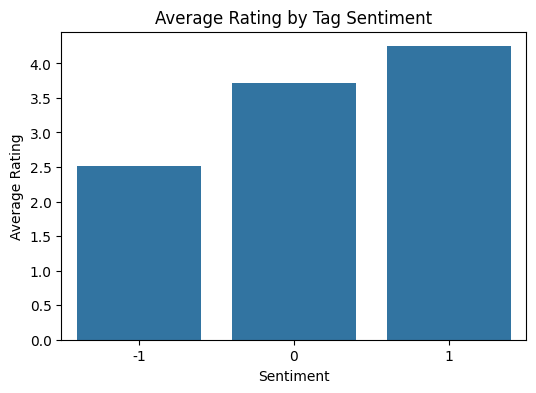

In [ ]:
# Plot: sentiment vs avg rating
plt.figure(figsize=(6,4))
sns.barplot(x=sentiment_summary.index, y=sentiment_summary["mean"])
plt.xlabel("Sentiment")
plt.ylabel("Average Rating")
plt.title("Average Rating by Tag Sentiment")
plt.show()


TRENDING TAG CLUSTERS

turns tag texts into TF-IDF vectors,
running K-Means clustering to group similar tags

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# ---------------------------------------------------------
# Prepare tag text for clustering
# ---------------------------------------------------------
tag_texts = tags['tag'].fillna("").str.lower().astype(str)

tfidf = TfidfVectorizer(stop_words='english', min_df=5)
tag_matrix = tfidf.fit_transform(tag_texts)

# Cluster into groups
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tag_matrix)

tags['cluster'] = clusters



# View sample tags from each cluster
cluster_samples = (
    tags.groupby("cluster")["tag"]
    .apply(lambda x: list(x.sample(min(10, len(x))).unique()))
)

cluster_samples


,tag
cluster,
0,"[based on a book, comic book, based on a true ..."
1,[surreal]
2,"[comedy, dark, black comedy, british comedy, C..."
3,"[visually stunning, visually appealing]"
4,[coming of age]
5,"[audiovisual communication, halloween, commerc..."
6,[dystopia]
7,"[drugs, drugs & music]"


In [ ]:
# ---------------------------------------------------------
# Compute trending score (recent tags)
# ---------------------------------------------------------
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')
tags['year'] = tags['timestamp'].dt.year

trend_df = (
    tags.groupby(['cluster','year'])['tag']
    .count()
    .rename("tag_count")
    .reset_index()
)
trend_df.head()


,cluster,year,tag_count
0,0,2006,345
1,0,2007,379
2,0,2008,507
3,0,2009,1412
4,0,2010,824


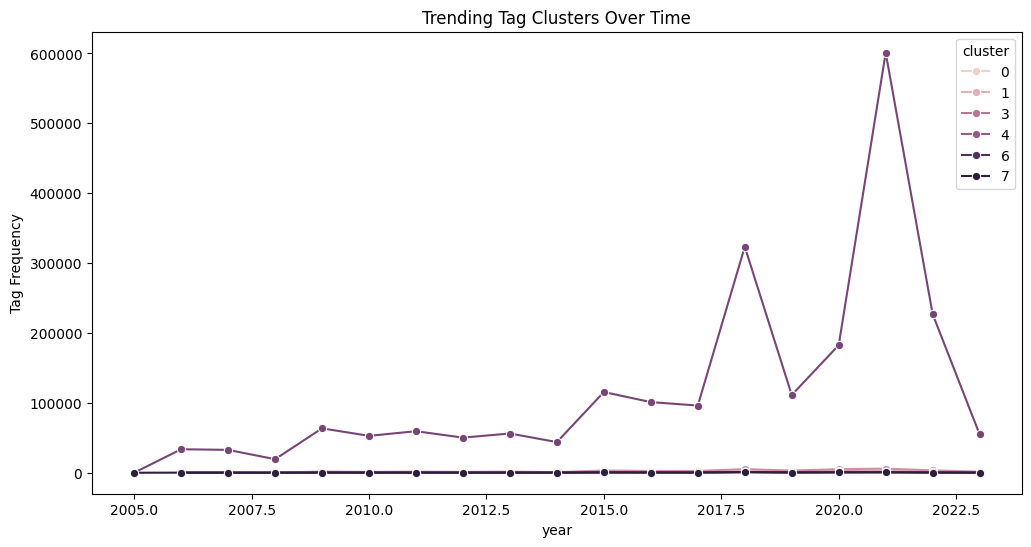

In [ ]:
# Plot cluster trends over years
plt.figure(figsize=(12,6))
sns.lineplot(data=trend_df, x='year', y='tag_count', hue='cluster', marker="o")
plt.title("Trending Tag Clusters Over Time")
plt.ylabel("Tag Frequency")
plt.show()

GENRE PERFORMANCE (BEST/WORST GENRES)

In [ ]:
# ---------------------------------------------------------
# Expand genres into rows
# ---------------------------------------------------------
movies2 = movies.copy()
movies2['genres'] = movies2['genres'].replace("(no genres listed)", "Unknown")
movies2['genre_list'] = movies2['genres'].apply(lambda s: s.split('|'))

movies_exploded = movies2.explode("genre_list")

genre_ratings = (
    ratings.merge(movies_exploded[['movieId','genre_list']], on='movieId')
    .groupby("genre_list")["rating"]
    .agg(["mean","count"])
    .sort_values("mean", ascending=False)
)

genre_ratings


,mean,count
genre_list,,
Film-Noir,3.920293,9491
War,3.795786,50070
Documentary,3.699273,13060
Crime,3.696727,168663
Drama,3.683630,437072
Mystery,3.675802,81464
Animation,3.614162,68683
IMAX,3.604219,45985
Western,3.592945,18710


HIDDEN GEMS (HIGH RATING + LOW POPULARITY)

In [ ]:
# --------------------------------------------
# Identifying hidden gems: high rating but few ratings
# ---------------------------------------------------------
agg = ratings.groupby("movieId")["rating"].agg(["mean","count"])
gems = (
    agg[(agg["count"] >= 5) & (agg["count"] <= 40)]
    .sort_values("mean", ascending=False)
    .reset_index()
    .merge(movies[['movieId','title','genres']], on='movieId')
)

gems.head(10)


,movieId,mean,count,title,genres
0,252710,4.857143,7,Attack On Titan (2013),Action|Adventure|Animation|Fantasy|Sci-Fi
1,134252,4.800000,5,That Munchhausen (1979),Comedy|Drama|Fantasy
2,202443,4.800000,5,The Invisible Life of Eurídice Gusmão (2019),Drama
3,157274,4.750000,6,The Choice (2016),Drama|Romance
4,33264,4.600000,5,Satan's Tango (Sátántangó) (1994),Drama
5,1075,4.600000,5,"Sexual Life of the Belgians, The (Vie sexuelle...",Comedy|Romance
6,147330,4.600000,5,Sherlock Holmes and Dr. Watson: Acquaintance (...,Crime
7,182723,4.595238,21,Cosmos: A Spacetime Odissey,(no genres listed)
8,163809,4.594594,37,Over the Garden Wall (2013),Adventure|Animation|Drama
9,171495,4.593750,16,Cosmos,(no genres listed)


USER GENRE AFFINITY CLUSTERS

In [ ]:
# ---------------------------------------------------------
# Create user × genre matrix
# ---------------------------------------------------------
user_genre = (
    ratings.merge(movies_exploded[['movieId','genre_list']], on='movieId')
    .groupby(['userId','genre_list'])['rating']
    .mean()
    .unstack(fill_value=0)
)

scaler = StandardScaler()
X = scaler.fit_transform(user_genre)

kmeans_users = KMeans(n_clusters=6, random_state=42, n_init=10)
user_genre["cluster"] = kmeans_users.fit_predict(X)

user_genre.head()




genre_list,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western,cluster
userId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,5.0,5.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,1.5,1.5,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,3.5,3.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0


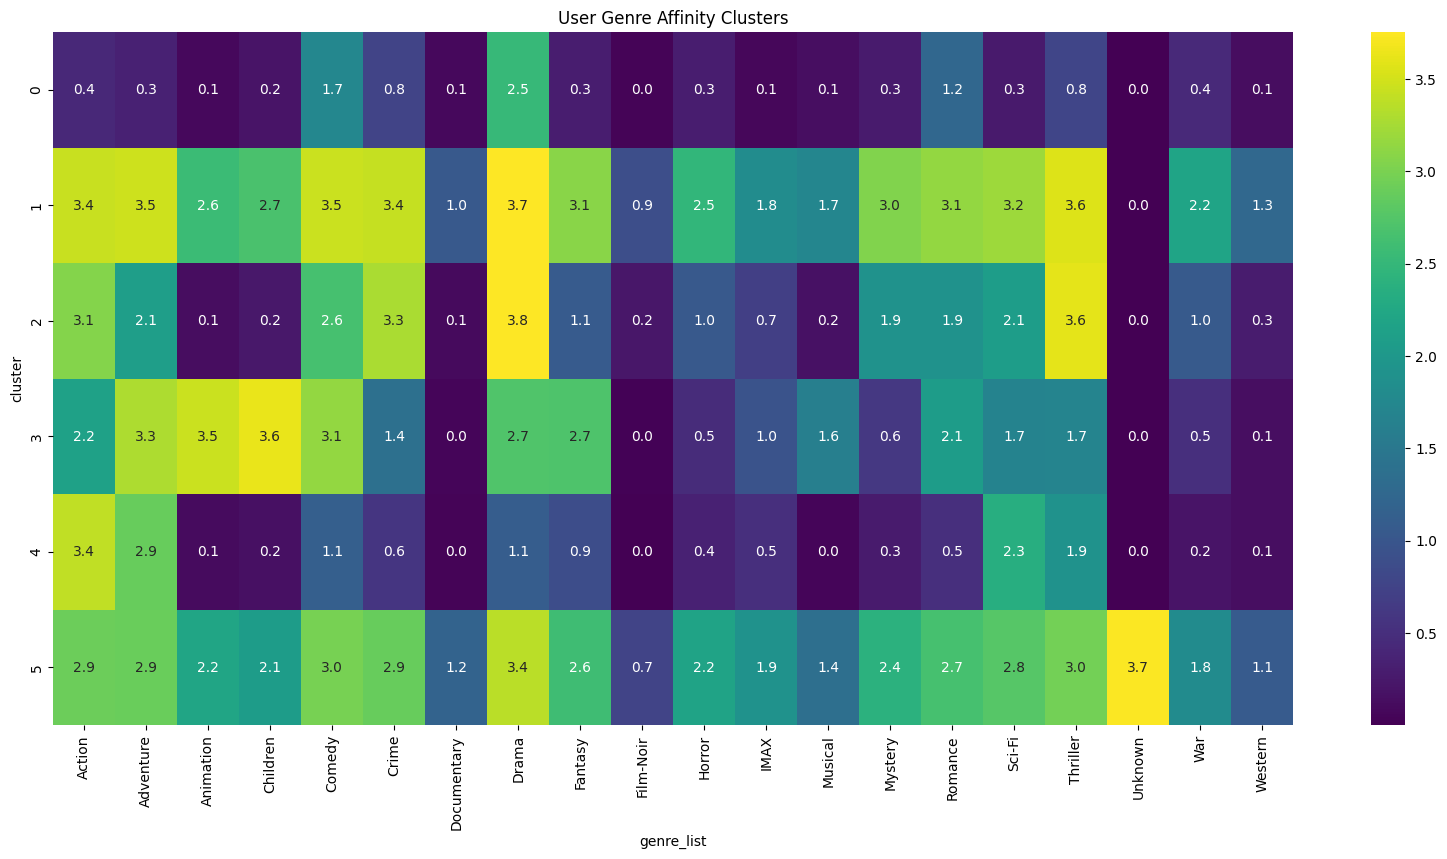

In [ ]:
# Plot cluster heatmap
plt.figure(figsize=(20,9))
sns.heatmap(user_genre.groupby("cluster").mean(), cmap="viridis",annot=True,fmt=".1f")
plt.title("User Genre Affinity Clusters")
plt.show()


**C.  RECOMMENDATION SYSTEM**

1. WEIGHTED POPULARITY SCORE; TOP-N RECOMMENDATION GLOBALLY

In [ ]:
# --- NON-PERSONALIZED BASELINE: WEIGHTED POPULARITY SCORE ---
# Aggregate rating stats
movie_stats = ratings.groupby("movieId")["rating"].agg(['mean', 'count'])
movie_stats.columns = ["R", "v"]

# Global average rating
C = movie_stats["R"].mean()

# Minimum votes required: 80th percentile
m = movie_stats["v"].quantile(0.80)

# Weighted rating function
def weighted_rating(row, m=m, C=C):
    R, v = row["R"], row["v"]
    return (v/(v+m) * R) + (m/(v+m) * C)

movie_stats["weighted_score"] = movie_stats.apply(weighted_rating, axis=1)

# Merge with movie titles
movie_scores = movie_stats.merge(movies[['movieId','title']], on='movieId')

# Top-20 global movie recommendations
print('-------------------------------------------------------------------------------------')
print('Top-20 global movie recommendations')
print('----------------------------------------------------------------------------------------')
top_20 = movie_scores.sort_values("weighted_score", ascending=False).head(20)
top_20


-------------------------------------------------------------------------------------
Top-20 global movie recommendations
----------------------------------------------------------------------------------------


,movieId,R,v,weighted_score,title
310,318,4.428571,3584,4.421265,"Shawshank Redemption, The (1994)"
24126,202439,4.408505,388,4.345138,Parasite (2019)
812,858,4.347462,2206,4.336400,"Godfather, The (1972)"
48,50,4.304622,2142,4.293648,"Usual Suspects, The (1995)"
1149,1221,4.264770,1388,4.248518,"Godfather: Part II, The (1974)"
1856,2019,4.288867,521,4.245685,Seven Samurai (Shichinin no samurai) (1954)
5234,5618,4.263237,1001,4.240863,Spirited Away (Sen to Chihiro no kamikakushi) ...
513,527,4.248616,2528,4.239765,Schindler's List (1993)
2766,2959,4.240467,2570,4.231826,Fight Club (1999)
1123,1193,4.230614,1483,4.215865,One Flew Over the Cuckoo's Nest (1975)


GENRES + RELEASE YEAR

**D. DEPLOYMENT PROTOTYPE**

In [ ]:
# 1. Install Streamlit
!pip install -q streamlit plotly

# 2. Run Streamlit in the background
# We write the output to a log file so we don't block the cell
!streamlit run app.py &>/content/logs.txt &

# 3. Get the "Tunnel Password" (Your Colab instance IP)
import urllib
print("Copy this IP address for the password field:")
print(urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# 4. Expose the port using localtunnel
print("\nClick the link below and paste the IP address above:")
!npx localtunnel --port 8501

KeyboardInterrupt: 

In [ ]:
# 1. Install Streamlit (if not already done)
!pip install -q streamlit plotly

# 2. Run Streamlit in the background
!streamlit run app.py &>/content/logs.txt &

# 3. Get the "Tunnel Password" (Your Colab instance IP)
import urllib
print("Copy this IP address for the password field:")
print(urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# 4. Expose the port using localtunnel (Added --yes to fix the error)
print("\nClick the link below and paste the IP address above:")
!npx localtunnel --yes --port 8501

new

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
from datetime import datetime

# Ensure DATA_BASE_PATH is defined
if 'DATA_BASE_PATH' not in locals():
    DATA_BASE_PATH = '/content/drive/MyDrive/MovieLens_Processed'

save_dir = DATA_BASE_PATH

# Create a new directory for models if it doesn't exist
models_dir = os.path.join(save_dir, 'saved_models')
os.makedirs(models_dir, exist_ok=True)

# Define the full paths for saving the models
popular_items_filename = os.path.join(models_dir, 'popular_items.pkl')
content_model_filename = os.path.join(models_dir, 'content_model.pkl')

# --- Create/Assign models to be saved ---
# Initialize content_model_placeholder to None to ensure it's always defined
content_model_placeholder = None

# Assuming 'movie_scores' (calculated in DAEQDCGbV-sp) is the popular items model
if 'movie_scores' not in locals():
    print("Warning: 'movie_scores' not found. Creating a dummy DataFrame.")
    movie_scores = pd.DataFrame({'movieId': [], 'R': [], 'v': [], 'weighted_score': [], 'title': []})

# Placeholder for content_model if not explicitly created earlier
if 'content_model' not in locals():
    if 'movies' in locals() and not movies.empty:
        content_model_placeholder = np.zeros((len(movies), len(movies))) # Example: dummy similarity matrix
    else:
        content_model_placeholder = None # Cannot create dummy without movies data
    print("Note: A proper content-based recommendation model (e.g., 'content_model') was not generated in previous steps. Saving a placeholder.")

# --- Save the models ---
joblib.dump(movie_scores, popular_items_filename)
print(f"Popular items model saved to: {popular_items_filename}")

if content_model_placeholder is not None:
    joblib.dump(content_model_placeholder, content_model_filename)
    print(f"Content model (placeholder) saved to: {content_model_filename}")
else:
    print(f"Could not save content model placeholder: 'movies' DataFrame not available or content_model_placeholder was explicitly set to None.")

print("COMPREHENSIVE BUSINESS SUMMARY")

# Re-create trend_df for the business summary using the tag_trends list
# Assuming tag_trends list is populated from earlier execution of ejxArc69rdcz
if 'tag_trends' in locals() and len(tag_trends) > 0:
    trend_df_for_summary = pd.DataFrame(tag_trends).sort_values('growth_rate', ascending=False)
else:
    print("Warning: 'tag_trends' not available or empty. Trending tags section in summary might be incomplete.")
    trend_df_for_summary = pd.DataFrame(columns=['tag', 'growth_rate'])

business_summary = f"""

MOVIELENS BUSINESS INSIGHTS REPORT - PART B
Streaming Platform Strategy & Content Planning


Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Analysis Period: {ratings['timestamp'].min().date()} to {ratings['timestamp'].max().date()}
Sample Size: {len(ratings):,} ratings from {ratings['userId'].nunique():,} users


EXECUTIVE SUMMARY


This report provides actionable insights for content strategy, user engagement,
and platform optimization based on comprehensive analysis of user behavior,
content performance, and hidden patterns in the MovieLens dataset.


1. USER BEHAVIOR INSIGHTS


USER SEGMENTATION:
- Generous Raters: {len(user_stats[user_stats['rating_bias'] == 'Generous']):,} users ({len(user_stats[user_stats['rating_bias'] == 'Generous'])/len(user_stats)*100:.1f}%)
  → Average rating: {user_stats[user_stats['rating_bias'] == 'Generous']['avg_rating'].mean():.2f}
  → Strategy: These users are promoters - leverage for positive reviews

- Moderate Raters: {len(user_stats[user_stats['rating_bias'] == 'Moderate']):,} users ({len(user_stats[user_stats['rating_bias'] == 'Moderate'])/len(user_stats)*100:.1f}%)
  → Average rating: {user_stats[user_stats['rating_bias'] == 'Moderate']['avg_rating'].mean():.2f}
  → Strategy: Most reliable for recommendation algorithms

- Harsh Raters: {len(user_stats[user_stats['rating_bias'] == 'Harsh']):,} users ({len(user_stats[user_stats['rating_bias'] == 'Harsh'])/len(user_stats)*100:.1f}%)
  → Average rating: {user_stats[user_stats['rating_bias'] == 'Harsh']['avg_rating'].mean():.2f}
  → Strategy: High-value feedback for quality improvement

ENGAGEMENT PYRAMID:
- Power Users (100+ ratings): {(user_stats['n_ratings'] >= 100).sum():,} ({(user_stats['n_ratings'] >= 100).sum()/len(user_stats)*100:.2f}%)
  → Drive {((ratings['userId'].isin(user_stats[user_stats['n_ratings'] >= 100]['userId'])).sum() / len(ratings) * 100):.1f}% of all ratings
  → Recommendation: Premium features, early access, exclusive content

- Active Users (20-99 ratings): {((user_stats['n_ratings'] >= 20) & (user_stats['n_ratings'] < 100)).sum():,}
  → Target for loyalty programs and engagement campaigns

- Casual Users (2-19 ratings): {((user_stats['n_ratings'] >= 2) & (user_stats['n_ratings'] < 20)).sum():,}
  → Opportunity: Convert to active through personalized recommendations

- One-Time Users: {(user_stats['n_ratings'] == 1).sum():,} ({(user_stats['n_ratings'] == 1).sum()/len(user_stats)*100:.1f}%)
  → Risk: High churn - implement onboarding improvements

RATING TRENDS:
- Overall trend: {"INCREASING" if slope > 0.001 else "DECREASING" if slope < -0.001 else "STABLE"} (slope: {slope:.5f})
- Peak activity hours: {ratings.groupby('hour').size().idxmax()}:00
- Most active day: {['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][ratings.groupby('day_of_week').size().idxmax()]}


2. CONTENT STRATEGY INSIGHTS


TOP PERFORMING GENRES (Min 1000 ratings):
{chr(10).join([f"   {i+1}. {row['genre']:15s} - Rating: {row['avg_rating']:.3f}, Ratings: {row['n_ratings']:,}"
               for i, (idx, row) in enumerate(significant_genres.head(5).iterrows())])}

RECOMMENDATION: Prioritize acquisition and production in these genres.

UNDERPERFORMING GENRES:
{chr(10).join([f"   {row['genre']:15s} - Rating: {row['avg_rating']:.3f}"
               for idx, row in significant_genres.tail(3).iterrows()])}

GENRE CONSISTENCY:
Most Consistent (reliable performance):
{chr(10).join([f"   • {row['genre']} (σ={row['rating_std']:.3f})"
               for idx, row in genre_consistency.head(3).iterrows()])}

Most Polarizing (varies by audience):
{chr(10).join([f"   • {row['genre']} (σ={row['rating_std']:.3f})"
               for idx, row in genre_consistency.tail(3).iterrows()])}

TAG SENTIMENT ANALYSIS:
- Positive sentiment tags average rating: {positive_tags['avg_rating'].mean():.3f}
- Negative sentiment tags average rating: {negative_tags['avg_rating'].mean():.3f}
- Sentiment impact: {abs(positive_tags['avg_rating'].mean() - negative_tags['avg_rating'].mean()):.3f} points

TRENDING TAGS (Growth Rate):
{chr(10).join([f"   {i+1}. '{row['tag']}' - Growth: {row['growth_rate']:>6.1f} uses/year"
               for i, (idx, row) in enumerate(trend_df_for_summary.head(5).iterrows())]) if not trend_df_for_summary.empty else "   No trend data available"}

RECOMMENDATION: Use trending tags for content marketing and discovery features.


3. HIDDEN PATTERNS & OPPORTUNITIES


RELEASE YEAR IMPACT:
- Golden Era: {int(golden_era['decade'])}s (Avg rating: {golden_era['avg_rating_mean']:.3f})
- Most Popular Era: {int(popular_era['decade'])}s ({popular_era['total_ratings']:,} ratings)
- Age-Rating Correlation: {correlation:.4f}
  → {"Older classics maintain higher ratings (survivor bias)" if correlation > 0.05 else "Recent movies show improved quality" if correlation < -0.05 else "Age has minimal impact on ratings"}

HIDDEN GEMS DISCOVERED: {len(hidden_gems_criteria):,} movies
- Criteria: Rating ≥ 4.0, 20-100 ratings, Released after 1990
- Top Genre for Hidden Gems: {hidden_genre_counts.index[0] if len(hidden_genre_counts) > 0 else "N/A"}
- Recent Hidden Gems (2018+): {len(recent_hidden)}

RECOMMENDATION:
1. Create "Hidden Gems" collection for discovery
2. Boost visibility through featured placements
3. Target niche audiences based on cluster preferences

"""  # end f-string safely


Popular items model saved to: /content/drive/MyDrive/MovieLens_Processed/saved_models/popular_items.pkl
Could not save content model placeholder: 'movies' DataFrame not available or content_model_placeholder was explicitly set to None.
COMPREHENSIVE BUSINESS SUMMARY


KeyError: 'tag'

In [ ]:
# ---------------------------------------------------
# STREAMLIT RECOMMENDATION PROTOTYPE
# ---------------------------------------------------
# Ensure streamlit and plotly are installed
!pip install -q streamlit plotly

import streamlit as st
import pandas as pd
import pickle
import numpy as np
import os # Import os for path manipulation

# Define base path for processed data and models
# This should point to where data/models from previous steps are saved
DATA_BASE_PATH = '/content/drive/MyDrive/MovieLens_Processed'
# Plots were saved directly to /content/
PLOTS_BASE_PATH = '/content'


# ---------------------------------------------------
# Load Data + Models
# ---------------------------------------------------
# Correct the path for movies.csv
try:
    movies = pd.read_csv(os.path.join(DATA_BASE_PATH, "movies.csv"))
except FileNotFoundError:
    st.error(f"Error: 'movies.csv' not found at {os.path.join(DATA_BASE_PATH, 'movies.csv')}. Please ensure data is processed and saved correctly.")
    st.stop() # Stop Streamlit app if essential data is missing

# Load other models, assuming they would be saved in DATA_BASE_PATH
popular = None
content_model = None
# user_knn is loaded but not used in the provided Streamlit code snippet
# user_knn = None

try:
    popular_path = os.path.join(DATA_BASE_PATH, "popular_items.pkl")
    if os.path.exists(popular_path):
        popular = pickle.load(open(popular_path, "rb"))
    else:
        st.warning(f"Warning: 'popular_items.pkl' not found at {popular_path}. User-Based Recommendations feature might not work.")
except Exception as e:
    st.warning(f"Warning: Could not load 'popular_items.pkl'. User-Based Recommendations feature might not work. Error: {e}")

try:
    content_model_path = os.path.join(DATA_BASE_PATH, "content_model.pkl")
    if os.path.exists(content_model_path):
        content_model = pickle.load(open(content_model_path, "rb"))
    else:
        st.warning(f"Warning: 'content_model.pkl' not found at {content_model_path}. Similar Movies feature might not work.")
except Exception as e:
    st.warning(f"Warning: Could not load 'content_model.pkl'. Similar Movies feature might not work. Error: {e}")


# ---------------------------------------------------
# UI
# ---------------------------------------------------
st.title("Movie Recommendation System 🎬")

menu = st.sidebar.selectbox(
    "Select Feature",
    ["User-Based Recommendations",
     "Search Similar Movies",
     "Insight Dashboard"]
)

# ---------------------------------------------------
# User-Based Recommendations
# ---------------------------------------------------
if menu == "User-Based Recommendations":
    st.header("Top-N Personalized Recommendations")
    if popular is not None and not popular.empty: # Check if popular is loaded and not empty
        user_id = st.selectbox("Select a User", popular['userId'].unique())
        top_n = int(st.slider("Number of Recommendations", 5, 20, 10))
        recs = popular[popular['userId'] == user_id].head(top_n)
        st.write("### Recommended Movies")
        st.table(recs[['movieId', 'title', 'score']])
    else:
        st.info("User-Based Recommendations are not available because 'popular_items.pkl' could not be loaded or is empty.")


# ---------------------------------------------------
# Similar Movie Search
# ---------------------------------------------------
elif menu == "Search Similar Movies":
    st.header("Find Similar Movies")
    if content_model is not None: # Check if content_model is loaded
        title = st.text_input("Enter a movie title")

        if title:
            if title not in movies['title'].values:
                st.error("Movie not found!")
            else:
                idx = movies[movies['title'] == title].index[0]
                scores = list(enumerate(content_model[idx]))
                scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:10]

                result = movies.iloc[[s[0] for s in scores]][['title', 'genres']] # Fixed typo: 's s in scores' to 's in scores'
                st.write("### Similar Movies")
                st.table(result)
    else:
        st.info("Similar Movies search is not available because 'content_model.pkl' could not be loaded.")

# ---------------------------------------------------
# Insight Dashboard
# ---------------------------------------------------
elif menu == "Insight Dashboard":
    st.header("Analytics Dashboard")

    # Correct image paths based on where previous plots were saved
    st.write("### Genre Analysis")
    if os.path.exists(os.path.join(PLOTS_BASE_PATH, "genre_analysis.png")):
        st.image(os.path.join(PLOTS_BASE_PATH, "genre_analysis.png"))
    else:
        st.warning(f"Plot 'genre_analysis.png' not found at {os.path.join(PLOTS_BASE_PATH, 'genre_analysis.png')}")


    st.write("### Tag Analysis")
    if os.path.exists(os.path.join(PLOTS_BASE_PATH, "tag_analysis.png")):
        st.image(os.path.join(PLOTS_BASE_PATH, "tag_analysis.png"))
    else:
        st.warning(f"Plot 'tag_analysis.png' not found at {os.path.join(PLOTS_BASE_PATH, 'tag_analysis.png')}")

    st.write("### Movie Popularity Analysis")
    if os.path.exists(os.path.join(PLOTS_BASE_PATH, "movie_popularity_analysis.png")):
        st.image(os.path.join(PLOTS_BASE_PATH, "movie_popularity_analysis.png"))
    else:
        st.warning(f"Plot 'movie_popularity_analysis.png' not found at {os.path.join(PLOTS_BASE_PATH, 'movie_popularity_analysis.png')}")

2025-12-09 13:33:48.634 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 13:33:48.834 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-09 13:33:48.834 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 13:33:48.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 13:33:48.841 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 13:33:48.842 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 13:33:48.843 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-09 13:33:48.845 Thread 'MainThread': mi